In [1]:
# IMPORT LIBRARY

#basic librairy
import numpy
import pandas
import xarray
import matplotlib

#dicuss with the machine
import sys
import os
import subprocess
import traceback
import pyperclip

#following long process
from tqdm import tqdm

#for plotting 
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap
from pyrolite.util.time import Timescale

#for the Qt window
from PySide6.QtWidgets import QApplication, QDialog, QFileDialog, QColorDialog, QMainWindow, QMessageBox, QHBoxLayout, QVBoxLayout, QWidget, QComboBox, QPushButton, QLabel, QLineEdit, QProgressBar, QDockWidget, QSizePolicy, QMenu
from PySide6.QtGui import QFont, QCloseEvent, QColor, QImage, QPixmap, QClipboard
from PySide6.QtCore import Qt, QThread, Signal, QObject

from matplotlib.backends.backend_qtagg import FigureCanvasQTAgg
from matplotlib.backends.backend_qt import NavigationToolbar2QT
from magicgui.backends._qtpy import show_file_dialog


In [2]:
# INITIALIZE GLOBAL VARIABLE (as minimum as possible...)

# load an initial color liste for sample
global tab_color
tab_color = {}
n=1
for item, value in matplotlib.colors.TABLEAU_COLORS.items():
    tab_color["sample " + str(n)] = matplotlib.colors.hex2color(value)
    n = n + 1
del n

#font size and figure parameters :
font_size = 11
params = {
         'legend.title_fontsize': font_size + 2,
         'legend.fontsize': font_size,
         'axes.labelsize': font_size,
         'axes.titlesize':font_size + 2,
         'xtick.labelsize':font_size - 2,
         'ytick.labelsize':font_size - 2,
         'font.size':font_size - 2,
         "axes.titlecolor": "black",
         "axes.labelcolor": "black",
         "xtick.color": "black",
         "ytick.color": "black",
         }
matplotlib.pyplot.rcParams.update(params)

In [3]:
# === SUB FUNCTION === #

def get_chemin(n, tab_destination, dataframe, dataframe_2, max_p, nb_p, column):
    if nb_p == max_p:
        tab_destination[n,:,0]=dataframe.Time
        tab_destination[n,:,1]=dataframe[column]
    else:
        data_temp = dataframe.Time
        tab_destination[n,:,0]=numpy.pad(data_temp, (0 ,max_p-nb_p), 'constant', constant_values='nan')
        data_temp = dataframe[column]
        tab_destination[n,:,1]=numpy.pad(data_temp, (0 ,max_p-nb_p), 'constant', constant_values='nan')
    if isinstance(dataframe_2, pandas.DataFrame):
        tab_destination[n,1,2]=dataframe_2.iloc[0].Like
        tab_destination[n,2,2]=dataframe_2.iloc[0].Posterior
        
def get_He(n, echant_nom, nb_He, tab_destination, dataframe, filtre):
    
    a = dataframe[dataframe.Nom.str.fullmatch('He_' + echant_nom) & dataframe.type.str.contains(filtre) & dataframe.type_bis.str.contains('1')].Pred_ages
    b = nb_He-len(a)

    #pred Ages
    data_temp = dataframe[dataframe.Nom.str.fullmatch('He_' + echant_nom) & dataframe.type.str.contains(filtre) & dataframe.type_bis.str.contains('1')].Pred_ages
    tab_destination[n,:,0] = numpy.pad(data_temp, (0 ,b), 'constant', constant_values='nan')
    #error
    data_temp = ''
    tab_destination[n,:,1] = numpy.pad(data_temp, (0 ,nb_He), 'constant', constant_values='nan')
    #obs Ages
    data_temp = dataframe[dataframe.Nom.str.fullmatch('He_' + echant_nom) & dataframe.type.str.contains(filtre) & dataframe.type_bis.str.contains('1')].Obs_age
    tab_destination[n,:,2] = numpy.pad(data_temp, (0 ,b), 'constant', constant_values='nan')
    #error
    data_temp = dataframe[dataframe.Nom.str.fullmatch('He_' + echant_nom) & dataframe.type.str.contains(filtre) & dataframe.type_bis.str.contains('1')].Error
    tab_destination[n,:,3] = numpy.pad(data_temp, (0 ,b), 'constant', constant_values='nan')
    #Rs
    data_temp = dataframe[dataframe.Nom.str.fullmatch('He_' + echant_nom) & dataframe.type.str.contains(filtre) & dataframe.type_bis.str.contains('1')].Rs
    tab_destination[n,:,4] = numpy.pad(data_temp, (0 ,b), 'constant', constant_values='nan')
    #Tc
    data_temp = dataframe[dataframe.Nom.str.fullmatch('He_' + echant_nom) & dataframe.type.str.contains(filtre) & dataframe.type_bis.str.contains('1')].Tc
    tab_destination[n,:,5] = numpy.pad(data_temp, (0 ,b), 'constant', constant_values='nan')
    #eU
    data_temp = dataframe[dataframe.Nom.str.fullmatch('He_' + echant_nom) & dataframe.type.str.contains(filtre) & dataframe.type_bis.str.contains('1')].eU
    tab_destination[n,:,6] = numpy.pad(data_temp, (0 ,b), 'constant', constant_values='nan')
    #Pred Ages (Corr)
    data_temp = dataframe[dataframe.Nom.str.fullmatch('He_' + echant_nom) & dataframe.type.str.contains(filtre) & dataframe.type_bis.str.contains('1')].Cor_Pred_age
    tab_destination[n,:,7] = numpy.pad(data_temp, (0 ,b), 'constant', constant_values='nan')
    #Crystal
    data_temp = dataframe[dataframe.Nom.str.fullmatch('He_' + echant_nom) & dataframe.type.str.contains(filtre) & dataframe.type_bis.str.contains('1')].Crystal
    tab_destination[n,:,9] = numpy.pad(data_temp, (0 ,b), 'constant', constant_values='nan')

def get_scale(total):
    total=int(total)
    if total >= 1000:
        max_scale = 250
        min_scale = 50
    elif 1000 > total >= 400 :
        max_scale = 100
        min_scale = 25
    elif 400 > total >= 150 :
        max_scale = 50
        min_scale = 10
    elif 150 > total >= 35 :
        max_scale = 25
        min_scale = 5
    elif 35 > total >= 15 :
        max_scale = 5
        min_scale = 1
    elif 15 > total >= 2 :
        max_scale = 2
        min_scale = 0.25
    else:
        max_scale = 0.5
        min_scale = 0.05
    
    return max_scale, min_scale

def get_file(*, racine=''):
  
    if not QApplication.instance():
        app = QApplication([])
    else:
        app = QApplication.instance()

    if "win" in sys.platform:
        filepath, _ = QFileDialog.getOpenFileNames(None, 'Select one or multiple QTQt output file(s)', racine, 'Fichiers texte (*.txt)')
    else:
        filepath, _ = QFileDialog.getOpenFileNames(None, 'Select one or multiple QTQt output file(s)', racine, 'Fichiers texte (*.txt)',  options=QFileDialog.Options() | QFileDialog.DontUseNativeDialog)

    return filepath

def get_path(*, name='', extension='svg', racine=''):
    if not QApplication.instance():
        app = QApplication([])
    else:
        app = QApplication.instance()
    default_name = name + "." + extension
    
    if "win" in sys.platform:
        path, _ = QFileDialog.getSaveFileName(None, 'Save As', default_name, 'All Files (*)')
    else:
        path, _ = QFileDialog.getSaveFileName(None, 'Save As', default_name, 'All Files (*)', options=QFileDialog.Options() | QFileDialog.DontUseNativeDialog)

    return path

def save_QTQt_fig (self, filepath, file_format, *,autopath=False):
    if autopath == False:
        file_name = filepath.replace(" ","_")
        test = file_name.split('/')
        file_name = test[len(test)-1]
        file_name = file_name.replace(".txt",'')
        complete_path = get_path(name= file_name, extension=file_format)
        complete_path = str(complete_path)
        complete_path = complete_path.replace("<_io.TextIOWrapper name='",'').replace("' mode='w' encoding='cp1252'>", '')
    else:
        complete_path = filepath.replace(".txt",'.' + file_format)
    self.figure.savefig(complete_path, format=file_format, bbox_inches='tight')
    
def def_valeur(valeur, remplacement):
    if 'nan' in valeur:
        text = remplacement
    elif '-' in valeur:
        text = remplacement
    elif float(valeur) == 0:
        text = remplacement
    else:
        if remplacement != '' :
            text = str(round(float(valeur)*100)) + "%"
        else:
            text = ' (' + str(round(float(valeur)*100)) + "%)"
    return text
        

In [4]:
# === GET SAMPLES color and info ===

def get_colorlist(data, tab_color_init, *, color_list=''):
    
    nb_file = int(data.iloc[0])
    files = data[1 : nb_file + 1]
    #files = files.squeeze()

    for index, row in files.iterrows():
        #row = row.str.replace(".txt","")
        row = row.str.replace(" ","_")
        test_1 = row.str.split(pat='/',n=-1, expand=True)
        test_2 = test_1[test_1.shape[1]-1].values
        nom_ech = test_2[0].split('.txt')
        files.loc[index,:] = nom_ech[0]
    
    if color_list == '': color_list = {} 
    sample = {}
    
    n=1
    for i in tab_color:
        if n > nb_file:
            pass
        else:
            nom = str(files.loc[n].values).replace("(",'').replace(")",'').replace("[","").replace("]","").replace("'","").replace(".txt","").replace("_"," ")
            if nom in color_list :
                pass
            else:
                color_list[nom] = tab_color_init[i]
            sample[n - 1] = nom
            n=n+1     
            
    return color_list, sample


In [5]:
# === GET INFO ===

def get_inversion_info(data):
    
    info_list = {}
    # empty_dataframe
    empty_dataframe = {}
    for i in range(0, 10):
        empty_dataframe[i] = [0]

    #info recuperation
    
    info_loc1 = data[data[data.columns[0]].str.contains('Monitoring')]
    info_1 = data[info_loc1.index[0]+1 : info_loc1.index[0]+2]
    info_1 = info_1.squeeze()
    info_1 = info_1.replace(' =', '_=').replace('  ', ' ')
    info_1 = info_1.split(' ')
    info_2 = data[info_loc1.index[0]+2 : info_loc1.index[0]+3]
    info_2 = info_2.squeeze()
    info_2 = info_2.replace(' =', '_=').replace('#IO ', ' #IO').replace('  -nan', '-nan').replace('  ', ' ')
    info_2 = info_2.split(' ')
    
    info_loc2 = data[data[data.columns[0]].str.contains('Max allowable dTdt')]
    info_3 = data[info_loc2.index[0] : info_loc2.index[0]+1]
    info_3 = info_3.squeeze()
    info_3 = info_3.replace(' =', '_=').replace('  ', ' ')
    info_3 = info_3.split(' ')
    
    info_loc3 = data[data[data.columns[0]].str.contains('AdaptiveTimestep')]
    if info_loc3.empty:
        info_4 = pandas.DataFrame(empty_dataframe)
        info_5 = pandas.DataFrame(empty_dataframe)
    else:
        info_4 = data[info_loc3.index[0]+1 : info_loc3.index[0]+2]
        info_4 = info_4.squeeze()
        info_4 = info_4.replace(' =', '_=').replace('  ', ' ')
        info_4 = info_4.split(' ')
        info_5 = data[info_loc3.index[0]+2 : info_loc3.index[0]+3]
        info_5 = info_5.squeeze()
        info_5 = info_5.replace(' =', '_=').replace('  ', ' ')
        info_5 = info_5.split(' ')
    
    info_6 = data.iloc[-2]
    info_6 = info_6.squeeze()
    info_6 = info_6.split(' ')
    info_7 = data.iloc[-1]
    info_7 = info_7.squeeze()
    info_7 = info_7.split(' ')
    
    info_loc4 = data[data[data.columns[0]].str.contains('Move 1 :')]
    info_8 = data[info_loc4.index[0] : info_loc4.index[0]+11]
    info_8 = info_8.squeeze()
    info_8 = info_8.str.split(n=-1, expand=True)
    info_8.rename(columns={4:"nb_prop", 5:"ratio_prop", 7:"nb_accep", 8:"ratio_accep"},inplace=True)
    
    #info association
    info_list['Thinning'] =int(info_1[5])
    if int(info_1[8]) == 0:
        info_list['Gaussian exploration'] = 'no'
    else:
        info_list['Gaussian exploration'] = 'yes'
    if int(info_1[11]) == 0:
        info_list['Keep complex history'] = 'yes'
    else:
        info_list['Keep complex history'] = 'no'
        
    if 'nan' or '-' in info_2[5]:
        info_list['offset gaussian'] = 'no'
    elif float(info_2[5]) == 0:
        info_list['offset gaussian'] = 'no'
    else:
        info_list['offset gaussian'] = str(round(float(info_2[5]),0)) + '°/km'
    info_list['time gaussian'] = float(info_2[1])
    info_list['temperature gaussian'] = float(info_2[3])
        
    if int(info_3[6]) == 0:
        info_list['allow reheating'] = 'yes'
    else:
        info_list['allow reheating'] = 'no'
    info_list['Max allowable dTdt'] = round(float(info_3[3]))
    info_list['Rate tolerance'] = round(float(info_3[9]))
    
    info_list['Temperature steps diffusion Ap'] = round(float(info_4[5]))
    info_list['Temperature steps diffusion Other'] = round(float(info_4[8]))
    info_list['Temperature steps radi dam Ap'] = round(float(info_5[6]))
    info_list['Temperature steps radi dam Other'] = round(float(info_5[9]))
    
    if round(float(info_6[0]),0)/60/60 >= 1:
        info_list['time burnin'] = str(round(float(info_6[0])/60/60,1)) + ' h.'
    else:
        info_list['time burnin'] = str(round(float(info_6[0])/60)) + ' min.'
        
    if round(float(info_7[0]),0)/60/60 >= 1:
        info_list['time total'] = str(round(float(info_7[0])/60/60,1)) + ' h.'
    else:
        info_list['time total'] = str(round(float(info_7[0])/60)) + ' min.'
        
    info_list['Acceptance time'] = round(float(info_8.ratio_accep.iloc[0]) * 100) 
    info_list['Acceptance temperature'] = round(float(info_8.ratio_accep.iloc[1]) * 100)
    info_list['Acceptance offset'] = def_valeur(info_8.ratio_accep.iloc[2],'')
    
    info_list['Acceptance Birth'] = round(float(info_8.ratio_accep.iloc[3]) * 100)
    info_list['Acceptance Death'] = round(float(info_8.ratio_accep.iloc[4]) * 100)
    
    info_list['FT resample'] = def_valeur(info_2[16], 'no')
    info_list['He resample'] = def_valeur(info_2[19], 'no')
    info_list['VR resample'] = def_valeur(info_2[22], 'no')
    
    info_list['Acceptance FT'] = def_valeur(info_8.ratio_accep.iloc[5],'')
    info_list['Acceptance He'] = def_valeur(info_8.ratio_accep.iloc[6],'')
    info_list['Acceptance Vitr'] = def_valeur(info_8.ratio_accep.iloc[7],'')
    
    if info_list['Acceptance FT'] == '': info_list['FT resample'] = 'no'
    if info_list['Acceptance He'] == '': info_list['He resample'] = 'no'
    if info_list['Acceptance Vitr'] == '': info_list['VR resample'] = 'no'
    
    if info_list['FT resample'] == 'no': info_list['Acceptance FT'] = ''
    if info_list['He resample'] == 'no': info_list['Acceptance He'] = ''
    if info_list['VR resample'] == 'no': info_list['Acceptance Vitr'] = ''
        
    return info_list


In [6]:
# === CHAIN === # def extract_tT_history(data, data_tT)

def extract_tT_history(data):
    
    Chain_loc = data[data[data.columns[0]].str.contains('CHAIN')]
    Chain = data[Chain_loc.index[0]+1 : Chain_loc.index[1]-1]
    Chain = Chain.squeeze()
    Chain_tab = Chain.str.split(n=-1, expand=True)
    tqdm_stream.write(' 20%]')
    Chain_tab.rename(columns={0:"Step",1:"Likelihood",2:"Posterior",3:"nb_point"},inplace=True)
    Chain_tab = Chain_tab.apply(pandas.to_numeric, errors='coerce')
    tqdm_stream.write(' 40%]')
    Chain_tab = Chain_tab.round(2)
    nb_ech = data.iloc[0].values
    tqdm_stream.write(' 60%]')
    
    # HISTOIRE : convertir le format QTQt vers un format utilsable en passant par un array 3D
    X = range(4) #time, temperature, Z, info iteration
    Y = range(Chain_tab.shape[1]-4)
    iteration = range(Chain_tab.shape[0])

    data_tT = xarray.DataArray(
        data=[[[numpy.nan for i in range(len(X))] for j in range(len(Y))] for k in range(len(iteration))],
        coords={'X': X, 'Y': Y, 'iteration': iteration},
        dims=('iteration','Y', 'X')
    )
    
    tqdm_stream.write(' 80%]')
    data_tT[:,0,3]=Chain_tab.Step
    data_tT[:,1,3]=Chain_tab.Likelihood
    data_tT[:,2,3]=Chain_tab.Posterior
    data_tT[:,3,3]=Chain_tab.nb_point

    #boucle dans les colonnes pour la recuperation
    i=0
    j=0
    if int(nb_ech) > 1:
        nb_data = 2
    else:
        nb_data = 1
        
    for column in Chain_tab.columns[4:]:
        data_tT[:,j,i]=Chain_tab[column]
        i = i+1
        if i > nb_data :
            i = 0
            j = j+1
    
    return data_tT


In [7]:
# === CONSTRAIN === # def extract_constrain(data)

def extract_constrain(data):
    # retriver the input constrains
    constrain_loc = data[data[data.columns[0]].str.contains('Setting tt points 1 =')]

    test = constrain_loc.squeeze()
    constrain_nb = test.split(' ')
    constrain = data[constrain_loc.index[0] + 1 : constrain_loc.index[0] + 1 + int(constrain_nb[5])]

    constrain_tab = constrain.squeeze()
    constrain_tab = constrain_tab.str.split(n=-1, expand=True)
    constrain_tab.rename(columns={0:"Time",1:"dTime",2:"Temp",3:"dTemp"},inplace=True)
    
    # retriver the sample constrains
    sample_constrain_loc = data[data[data.columns[0]].str.contains('Predep')]
    sample_constrain_tab = sample_constrain_loc.squeeze()
    sample_constrain_tab = sample_constrain_tab.str.split(n=-1, expand=True)
    sample_constrain_tab.rename(columns={1:"Time",2:"dTime",3:"Temp",4:"dTemp"},inplace=True)

    # merge data in a xarray
    X = range(5) #time, dtime, temperature, dtemperature, type
    Y = range(len(constrain_tab) + len(sample_constrain_tab)) #

    data_constrain = xarray.DataArray(
        data=[[numpy.empty for i in range(len(X))] for j in range(len(Y))],
        coords={'data': X, 'constrain_n': Y},
        dims=('constrain_n', 'data')
    )

    i=0
    for index, row in constrain_tab.iterrows():
        data_constrain[i,0]=row.Time
        data_constrain[i,1]=row.dTime
        data_constrain[i,2]=row.Temp
        data_constrain[i,3]=row.dTemp
        if i == 0 : 
            data_constrain[i,4]="explo_box"
        else:
            data_constrain[i,4]="external_contraint"
        i=i+1
    
    for index, row in sample_constrain_tab.iterrows():
        data_constrain[i,0]=row.Time
        data_constrain[i,1]=row.dTime
        data_constrain[i,2]=row.Temp
        data_constrain[i,3]=row.dTemp
        data_constrain[i,4]="sample_contraint"
        i=i+1
    
    return data_constrain


In [8]:
# === PREDICTED t(T) === # def extract_tT_pred(data, data_Chemin)

def extract_tT_pred(data):
    max_point = 3
    
    #bloc 1
    Chemin_loc = data[data[data.columns[0]].str.contains('Max Like')]
    nb_point_like = data[Chemin_loc.index[0]+2 : Chemin_loc.index[0]+3].values
    Chemin_val = data[Chemin_loc.index[0]+1 : Chemin_loc.index[0] + 3]
    Chemin_val_like = Chemin_val.squeeze()
    Chemin_val_like = Chemin_val_like.str.split(n=-1, expand=True)
    Chemin_val_like.rename(columns={2:"Like",4:"Posterior"},inplace=True)
    Chemin_point = data[Chemin_loc.index[0]+3 : Chemin_loc.index[0] + 3 + int(nb_point_like)]
    Chemin_point_like = Chemin_point.squeeze()
    Chemin_point_like = Chemin_point_like.str.split(n=-1, expand=True)
    Chemin_point_like.rename(columns={0:"point",1:"Time",2:"Temp",3:"Z"},inplace=True)
    max_point = max(int(nb_point_like),max_point)
    
    #bloc 2
    Chemin_loc = data[data[data.columns[0]].str.contains('Max Post')]
    nb_point_post = data[Chemin_loc.index[0]+2 : Chemin_loc.index[0]+3].values
    Chemin_val = data[Chemin_loc.index[0]+1 : Chemin_loc.index[0] + 3]
    Chemin_val_post = Chemin_val.squeeze()
    Chemin_val_post = Chemin_val_post.str.split(n=-1, expand=True)
    Chemin_val_post.rename(columns={2:"Like",4:"Posterior"},inplace=True)
    Chemin_point = data[Chemin_loc.index[0]+3 : Chemin_loc.index[0] + 3 + int(nb_point_post)]
    Chemin_point_post = Chemin_point.squeeze()
    Chemin_point_post = Chemin_point_post.str.split(n=-1, expand=True)
    Chemin_point_post.rename(columns={0:"point",1:"Time",2:"Temp",3:"Z"},inplace=True)
    max_point = max(int(nb_point_post),max_point)
    
    #bloc 3
    Chemin_loc = data[data[data.columns[0]].str.contains('EXPECTED')]
    nb_point_expect = data[Chemin_loc.index[0]+3 : Chemin_loc.index[0]+4].values
    nb_point_expect = nb_point_expect[0,0].split(' ')
    Chemin_point = data[Chemin_loc.index[0]+4 : Chemin_loc.index[0] + 4 + int(nb_point_expect[0])]
    Chemin_point_expect = Chemin_point.squeeze()
    Chemin_point_expect = Chemin_point_expect.str.split(n=-1, expand=True)
    Chemin_point_expect.rename(columns={0:"Time",1:"T_Expected",2:"T_Mode",3:"T_env_sup",4:"T_env_inf"},inplace=True)
    max_point = max(int(nb_point_expect[0]),max_point)
    
    #recup dans un xarray
    X = range(3) #time, temperature, info
    Y = range(max_point)
    Chemin = range(6)
    #data_tT.clear()
    data_Chemin = xarray.DataArray(
        data=[[[numpy.empty for i in range(len(X))] for j in range(len(Y))] for k in range(len(Chemin))],
        coords={'X': X, 'Y': Y, 'Chemin': Chemin},
        dims=('Chemin','Y', 'X')
    )
    
    get_chemin (0, data_Chemin, Chemin_point_like,Chemin_val_like, max_point, int(nb_point_like), 'Temp')
    data_Chemin[0,0,2]='Max likelihood'
    get_chemin (1, data_Chemin, Chemin_point_post,Chemin_val_post, max_point, int(nb_point_post), 'Temp')
    data_Chemin[1,0,2]='Max posterior'
    get_chemin (2, data_Chemin, Chemin_point_expect, "",max_point, int(nb_point_expect[0]), 'T_Expected')
    data_Chemin[2,0,2]='Expected model'
    get_chemin (3, data_Chemin, Chemin_point_expect, "",max_point, int(nb_point_expect[0]), 'T_Mode')
    data_Chemin[3,0,2]='Max mode model'
    get_chemin (4, data_Chemin, Chemin_point_expect, "",max_point, int(nb_point_expect[0]), 'T_env_sup')
    data_Chemin[4,0,2]='Envelope sup. (99%)'
    get_chemin (5, data_Chemin, Chemin_point_expect, "",max_point, int(nb_point_expect[0]), 'T_env_inf')
    data_Chemin[5,0,2]='Envelope inf. (99%)'

    return data_Chemin

In [9]:
# === PREDICTED t(T) for vertical profile === # def extract_tT_pred_vertical(data, sample_list):

def extract_tT_pred_vertical(data, sample_list):
    sample_path_loc = data[data[data.columns[0]].str.contains('Max Like|Max Post|EXPECTED|Sample ID|MODE')]
    nb_ech = int(data.loc[0])
    
    #determine the maximim point :
    max_point = 0
    mem_type = ""
    Mode = False
    n = 0
    for index, row in sample_path_loc.iterrows():
        if 'Max Like' in row[0]:
            mem_type = row[0] 
        if 'Max Post' in row[0]:
            mem_type = row[0]  
        if 'EXPECTED' in row[0]:
            mem_type = row[0]
        if 'MODE' in row[0]:
            if "END" in row[0]:
                Mode = False
            else:
                Mode = True
        if 'Sample ID' in row[0]:
            if 'Sample ID =' not in row[0]:
                if mem_type != "EXPECTED":
                    nb_constrain = int(data.iloc[index+1])
                    nb_point = int(data.iloc[index + 2 + nb_constrain]) + 1
                    if nb_point > max_point: max_point = nb_point
            else: 
                if Mode == False :
                    data_tempo = data.iloc[index+1].str.split(n=-1, expand=True) 
                    nb_point = int(data_tempo[0]) + 1
                    if nb_point > max_point: max_point = nb_point
    
    # prepare the xarray for data storage ()
    X = range(3) #time, temperature,info
    Y = range(max_point)
    Chemin = range(nb_ech * 3) # 1 sample = 3 paths (Like, post, expected) 
    data_Chemin = xarray.DataArray(
        data=[[[numpy.empty for i in range(len(X))] for j in range(len(Y))] for k in range(len(Chemin))],
        coords={'X': X, 'Y': Y, 'Chemin': Chemin},
        dims=('Chemin','Y', 'X')
    )
    
    #fill the xarray with the path
    mem_type = ""
    Mode = False
    n = 0
    for index, row in sample_path_loc.iterrows():
        if 'Max Like' in row[0]:
            mem_type = row[0] 
        if 'Max Post' in row[0]:
            mem_type = row[0]  
        if 'EXPECTED' in row[0]:
            mem_type = row[0]
        if 'MODE' in row[0]:
            if "END" in row[0]:
                Mode = False
            else:
                Mode = True
        if 'Sample ID' in row[0]:
            if 'Sample ID =' not in row[0]:
                if mem_type != "EXPECTED":
                    #retriver
                    data_tempo = row.str.split(n=-1, expand=True)
                    sample_ID = int(data_tempo[2])
                    nb_constrain = int(data.iloc[index+1])
                    nb_point = int(data.iloc[index + 2 + nb_constrain]) + 1
                    index_init = index + 3
                    #prepare
                    Chemin_point = data.iloc[index_init:index_init + nb_point].squeeze()
                    Chemin_point = Chemin_point.str.split(n=-1, expand=True)
                    Chemin_point.rename(columns={0:"Time",1:"Temp",2:"Gradiant",3:"?"},inplace=True)
                    
                    #input in xarray
                    data_Chemin[n,0,2] = sample_list[sample_ID]
                    data_Chemin[n,1,2] = mem_type
                    data_Chemin[n,0:nb_point,0] = Chemin_point.Time
                    data_Chemin[n,nb_point:,0] = numpy.full(max_point - (nb_point) , numpy.nan) #needed for the plotting
                    data_Chemin[n,0:nb_point,1] = Chemin_point.Temp
                    data_Chemin[n,nb_point:,1] = numpy.full(max_point - (nb_point) , numpy.nan)#needed for the plotting
                    n = n + 1

            else: 
                if Mode == False :
                    #retriver
                    data_tempo = row.str.split(n=-1, expand=True)
                    sample_ID = int(data_tempo[3])
                    data_tempo = data.iloc[index+1].str.split(n=-1, expand=True) 
                    nb_point = int(data_tempo[0]) + 1
                    index_init = index + 2   
                    
                    #prepare
                    Chemin_point = data.iloc[index_init:index_init + nb_point].squeeze()
                    Chemin_point = Chemin_point.str.split(n=-1, expand=True)
                    Chemin_point.rename(columns={0:"Time",1:"T_Expected",2:"T_Mode",3:"T_env_sup",4:"T_env_inf",9: "Gradiant"},inplace=True)

                    #input in xarray
                    data_Chemin[n,1,2] = sample_list[sample_ID]
                    data_Chemin[n,1,2] = mem_type
                    data_Chemin[n,0:nb_point,0] = Chemin_point.Time
                    data_Chemin[n,nb_point:,0] = numpy.full(max_point - (nb_point) , numpy.nan)#needed for the plotting
                    data_Chemin[n,0:nb_point,1] = Chemin_point.T_Expected
                    data_Chemin[n,nb_point:,1] = numpy.full(max_point - (nb_point) , numpy.nan)#needed for the plotting
                    n = n + 1
                    
    return data_Chemin

In [10]:
# === He AGES === # def extract_He_Ages(data, data_He_Maxlike, data_He_MaxPost, data_He_Expect):
         
def extract_He_Ages(data):
    # AGE : extraire du fichier Summary.txt les chemins
    He_Age_loc = data[data[data.columns[0]].str.contains('Max Like|Max Post|EXPECTED|File Name|He =|HeR')]
    nb_ech = int(data.loc[0])

    # nettoyage des echan sans helium
    nb_He = 0
    mem = ""
    mem_ech = 0
    mem_type = ""
    Expected = False
    mem_expected = 1
    for index, row in He_Age_loc.iterrows():
        if 'HeR =' in row[0]:
            He_Age_loc.loc[index,:] = row.str.replace("HeR =",'He_' + nom_ech)
            He_Age_loc.loc[index,:] = He_Age_loc.loc[index,:].str.replace("Pred Age", str(mem_type + " " + str(mem_expected)))

        if 'Max Like' in row[0]:
            mem_type = row[0] 
            He_Age_loc = He_Age_loc.drop(labels=[index], axis = 0)
        if 'Max Post' in row[0]:
            mem_type = row[0]  
            He_Age_loc = He_Age_loc.drop(labels=[index], axis = 0)
        if 'EXPECTED' in row[0]:
            mem_type = row[0]
            He_Age_loc = He_Age_loc.drop(labels=[index], axis = 0)
            Expected = True
            mem_expected = 0

        if 'File Name =' in row[0]:
            if Expected == True:
                mem_expected = mem_expected + 1
                if mem_expected > 2:
                    mem_expected = 1
            #row = row.str.replace(".txt","")
            row = row.str.replace(" ","_")
            test_1 = row.str.split(pat='/',n=-1, expand=True)
            nom_ech = str(test_1[test_1.shape[1]-1].values)
            nom_ech = nom_ech.replace("(",'').replace(")",'').replace("[","").replace("]","").replace("'","").replace(".txt","")
            He_Age_loc.loc[index,:] = nom_ech + " t " + mem_type + " " + str(mem_expected)
            mem_ech = mem_ech + 1
            if mem_ech > nb_ech:
                mem_ech = 1
                
        if 'NFT =' in row[0]:
            He_Age_loc = He_Age_loc.drop(labels=[index], axis = 0)
        elif 'He =' in row[0]:
            test = row.str.split(n=-1, expand=True)
            if int(test[2]) == 0:
                He_Age_loc = He_Age_loc.drop(labels=[mem, index], axis = 0)
            else:
                nb_He = max(nb_He,int(test[2]))
                He_Age_loc = He_Age_loc.drop(labels=[index], axis = 0)

        else:    
            mem = index
    
    if not He_Age_loc.empty:
        He_Age_loc = He_Age_loc.squeeze()
        He_Age_loc = He_Age_loc.str.replace("Max ","Max-")
        He_Age = He_Age_loc.str.split(n=-1, expand=True)
        He_Age.rename(columns={0:"Nom",1:"Rs",2:"type",3:"type_bis",5:"Pred_ages",9:"Obs_age",12:"Error",18:"Tc", 19:"Crystal",22:"eU",25:"Ft",28:"Cor_Pred_age"},inplace=True)
        nb_ech = He_Age[He_Age.Rs.str.contains('t') & He_Age.type.str.contains('Max-Like')].Nom.shape[0]
        
        #recup des He
        X = range(10) #Rs, Pred Ages, ±, Obs Ages, ±, Tc, crystal, eU, Pred Ages (Corr), echantillon + info
        if nb_He == 1:
            Y = range(nb_He + 1)
        else:        
            Y = range(nb_He)
        echantillon = range(nb_ech)

        #maxlike
        data_He_Maxlike = xarray.DataArray(
            data=[[[numpy.empty for i in range(len(X))] for j in range(len(Y))] for k in range(len(echantillon))],
            coords={'X': X, 'Y': Y, 'echantillon': echantillon},
            dims=('echantillon','Y', 'X')
        )
        #maxpost
        data_He_MaxPost = xarray.DataArray(
            data=[[[numpy.empty for i in range(len(X))] for j in range(len(Y))] for k in range(len(echantillon))],
            coords={'X': X, 'Y': Y, 'echantillon': echantillon},
            dims=('echantillon','Y', 'X')
        )
        #expect
        data_He_Expect = xarray.DataArray(
            data=[[[numpy.empty for i in range(len(X))] for j in range(len(Y))] for k in range(len(echantillon))],
            coords={'X': X, 'Y': Y, 'echantillon': echantillon},
            dims=('echantillon','Y', 'X')
        )

        data_He_Maxlike[:,0,8] = He_Age[He_Age.Rs.str.contains('t') & He_Age.type.str.contains('Max-Like')].Nom
        data_He_Maxlike[:,1,8] = He_Age[He_Age.Rs.str.contains('t') & He_Age.type.str.contains('Max-Like')].type
        data_He_MaxPost[:,0,8] = He_Age[He_Age.Rs.str.contains('t') & He_Age.type.str.contains('Max-Post')].Nom
        data_He_MaxPost[:,1,8] = He_Age[He_Age.Rs.str.contains('t') & He_Age.type.str.contains('Max-Post')].type
        data_He_Expect[:,0,8] = He_Age[He_Age.Rs.str.contains('t') & He_Age.type.str.contains('EXPECTED') & He_Age.type_bis.str.contains('1')].Nom
        data_He_Expect[:,1,8] = He_Age[He_Age.Rs.str.contains('t') & He_Age.type.str.contains('EXPECTED') & He_Age.type_bis.str.contains('1')].type

        for n in echantillon:
            ech = data_He_Maxlike[n,0,8].values
            get_He(n, ech ,nb_He, data_He_Maxlike, He_Age, 'Max-Like')
            get_He(n, ech ,nb_He, data_He_MaxPost, He_Age, 'Max-Post')
            get_He(n, ech ,nb_He, data_He_Expect, He_Age, 'EXPECTED')

        for n in echantillon: #calculate pred error
            data_He_Maxlike[n,:,1] = data_He_Maxlike[n,:,3].astype(dtype=float) / data_He_Maxlike[n,:,2].astype(dtype=float) * data_He_Maxlike[n,:,0].astype(dtype=float)
            data_He_MaxPost[n,:,1] = data_He_MaxPost[n,:,3].astype(dtype=float) / data_He_MaxPost[n,:,2].astype(dtype=float) * data_He_MaxPost[n,:,0].astype(dtype=float)
            data_He_Expect[n,:,1] = data_He_Expect[n,:,3].astype(dtype=float) / data_He_Expect[n,:,2].astype(dtype=float) * data_He_Expect[n,:,0].astype(dtype=float)
        
        return data_He_Maxlike, data_He_MaxPost, data_He_Expect
    
    else:
        
        return '', '', ''

In [11]:
# === FT AGES === # def extract_He_Ages(data, data_He_Maxlike, data_He_MaxPost, data_He_Expect)

def extract_FT_Ages(data):
    
    FT_Age_loc = data[data[data.columns[0]].str.contains('Max Like|Max Post|EXPECTED|File Name|Pred FT age')]
    nb_ech = int(data.loc[0])
    # nettoyage des echan sans AFT
    mem_type = ""
    mem_nom = ""
    mem_expected = 0
    Expected = False
    for index, row in FT_Age_loc.iterrows():

        if 'Max Like' in row[0]:
            mem_type = row.str.replace(" ","_")
            FT_Age_loc = FT_Age_loc.drop(labels=[index], axis = 0)
        elif 'Max Post' in row[0]:
            mem_type = row.str.replace(" ","_")
            FT_Age_loc = FT_Age_loc.drop(labels=[index], axis = 0)
        elif 'EXPECTED' in row[0]:
            mem_type = row.str.replace(" ","_")
            FT_Age_loc = FT_Age_loc.drop(labels=[index], axis = 0)
            Expected = True   

        elif 'File Name =' in row[0]:
            if Expected == True:
                mem_expected = mem_expected + 1
                if mem_expected > 2:
                    mem_expected = 1
            
            #row = row.str.replace(".txt","")
            row = row.str.replace(" ","_")
            test = row.str.split(pat='/',n=-1, expand=True)
            mem_nom = str(test[test.shape[1]-1].values).replace("(",'').replace(")",'').replace("[","").replace("]","").replace("'","").replace(".txt","")
            FT_Age_loc = FT_Age_loc.drop(labels=[index], axis = 0)

        elif 'Pred FT age =' in row[0]:
            test = row.str.split(n=-1, expand=True)
            if float(test[5]) == -1:
                FT_Age_loc = FT_Age_loc.drop(labels=[index], axis = 0)
            else:
                FT_Age_loc.loc[index] = FT_Age_loc.loc[index].str.replace("Pred FT", mem_nom + " " + str(mem_type.values) + " " + str(mem_expected))

    if not FT_Age_loc.empty:
        FT_Age_tab = FT_Age_loc.squeeze()
        FT_Age_tab = FT_Age_tab.str.split(n=-1, expand=True)
        FT_Age_tab.rename(columns={0:"nom",1:"type",2:"expect",5:"Pred_ages",6:"Obs_ages",20:"Error"},inplace=True)
        nb_FT = FT_Age_tab[FT_Age_tab.type.str.contains('Max_Like')].nom.shape[0]

        #recup dans un xarray
        X = range(6) #Pred_ages, dpred, Obs_ages, dobs, nom, type
        Y = range(1)
        echantillon = range(int(nb_FT))

        #1
        data_FT_like = xarray.DataArray(
            data=[[[numpy.empty for i in range(len(X))] for j in range(len(Y))] for k in range(len(echantillon))],
            coords={'X': X, 'Y': Y, 'echantillon': echantillon},
            dims=('echantillon', 'Y', 'X')
        )
        #2
        data_FT_post = xarray.DataArray(
            data=[[[numpy.empty for i in range(len(X))] for j in range(len(Y))] for k in range(len(echantillon))],
            coords={'X': X, 'Y': Y, 'echantillon': echantillon},
            dims=('echantillon', 'Y', 'X')
        )
        #3
        data_FT_expect = xarray.DataArray(
            data=[[[numpy.empty for i in range(len(X))] for j in range(len(Y))] for k in range(len(echantillon))],
            coords={'X': X, 'Y': Y, 'echantillon': echantillon},
            dims=('echantillon', 'Y', 'X')
        )

        data_FT_like[:,0,0]=FT_Age_tab[FT_Age_tab.type.str.contains('Max_Like')].Pred_ages
        data_FT_like[:,0,1]=FT_Age_tab[FT_Age_tab.type.str.contains('Max_Like')].Obs_ages
        data_FT_like[:,0,2]=FT_Age_tab[FT_Age_tab.type.str.contains('Max_Like')].Error
        data_FT_like[:,0,4]=FT_Age_tab[FT_Age_tab.type.str.contains('Max_Like')].nom
        data_FT_like[:,0,5]=FT_Age_tab[FT_Age_tab.type.str.contains('Max_Like')].type

        data_FT_post[:,0,0]=FT_Age_tab[FT_Age_tab.type.str.contains('Max_Post')].Pred_ages
        data_FT_post[:,0,1]=FT_Age_tab[FT_Age_tab.type.str.contains('Max_Post')].Obs_ages
        data_FT_post[:,0,2]=FT_Age_tab[FT_Age_tab.type.str.contains('Max_Post')].Error
        data_FT_post[:,0,4]=FT_Age_tab[FT_Age_tab.type.str.contains('Max_Post')].nom
        data_FT_post[:,0,5]=FT_Age_tab[FT_Age_tab.type.str.contains('Max_Post')].type

        data_FT_expect[:,0,0]=FT_Age_tab[FT_Age_tab.type.str.contains('EXPECTED') & FT_Age_tab.expect.str.contains('1')].Pred_ages
        data_FT_expect[:,0,1]=FT_Age_tab[FT_Age_tab.type.str.contains('EXPECTED') & FT_Age_tab.expect.str.contains('1')].Obs_ages
        data_FT_expect[:,0,2]=FT_Age_tab[FT_Age_tab.type.str.contains('EXPECTED') & FT_Age_tab.expect.str.contains('1')].Error
        data_FT_expect[:,0,4]=FT_Age_tab[FT_Age_tab.type.str.contains('EXPECTED') & FT_Age_tab.expect.str.contains('1')].nom
        data_FT_expect[:,0,5]=FT_Age_tab[FT_Age_tab.type.str.contains('EXPECTED') & FT_Age_tab.expect.str.contains('1')].type


        data_FT_like[:,0,3] = data_FT_like[:,0,2].astype(dtype=float) / data_FT_like[:,0,1].astype(dtype=float) * data_FT_like[:,0,0].astype(dtype=float)
        data_FT_post[:,0,3] = data_FT_post[:,0,2].astype(dtype=float) / data_FT_post[:,0,1].astype(dtype=float) * data_FT_post[:,0,0].astype(dtype=float)
        data_FT_expect[:,0,3] = data_FT_expect[:,0,2].astype(dtype=float) / data_FT_expect[:,0,1].astype(dtype=float) * data_FT_expect[:,0,0].astype(dtype=float)

        return data_FT_like, data_FT_post, data_FT_expect
    
    else:
        return '', '', ''



In [12]:
# === FT LENGTH === # def extract_He_Ages(data, data_He_Maxlike, data_He_MaxPost, data_He_Expect)

def extract_FT_Length(data):
    
    #handle modification from old QTQt version to find the position of LFT data (location was missing)
    FT_Length_loc = data[data[data.columns[0]].str.contains('Lc0')]
    if FT_Length_loc.empty:
        LFT_marker = '1 0.100000 0.000000 0.000000 0.000000'
        LFT_shift = 1
    else:
        LFT_marker = 'Lc0 '
        LFT_shift = 0
    
    FT_Length_loc = data[data[data.columns[0]].str.contains('Max Like|Max Post|EXPECTED|File Name|' + LFT_marker)]
    mem_type = ""
    mem_nom = ""
    mem_expected = 0
    Expected = False
    for index, row in FT_Length_loc.iterrows():

        if 'Max Like' in row[0]:
            mem_type = row.str.replace(" ","_")
            FT_Length_loc = FT_Length_loc.drop(labels=[index], axis = 0)
        elif 'Max Post' in row[0]:
            mem_type = row.str.replace(" ","_")
            FT_Length_loc = FT_Length_loc.drop(labels=[index], axis = 0)
        elif 'EXPECTED' in row[0]:
            mem_type = row.str.replace(" ","_")
            FT_Length_loc = FT_Length_loc.drop(labels=[index], axis = 0)
            Expected = True   

        elif 'File Name =' in row[0]:
            if Expected == True:
                mem_expected = mem_expected + 1
                if mem_expected > 2:
                    mem_expected = 1

            #row = row.str.replace(".txt","")
            row = row.str.replace(" ","_")
            test = row.str.split(pat='/',n=-1, expand=True)
            mem_nom = test[test.shape[1]-1].values
            FT_Length_loc = FT_Length_loc.drop(labels=[index], axis = 0)

        elif LFT_marker in row[0]:
            FT_Length_loc.loc[index] = str(mem_nom[0]) + " " + mem_type.values + " " + str(mem_expected)

    FT_Length_tab = FT_Length_loc.squeeze()
    FT_Length_tab = FT_Length_tab.str.split(n=-1, expand=True)
    FT_Length_tab.rename(columns={0:"nom",1:"type",2:"expect"},inplace=True)
    nb_ech = FT_Length_tab[FT_Length_tab.type.str.contains('Max_Like')].nom.shape[0]
    
    #recup des FT
    X = range(6) #lenght, nb_obs, nb_pred_maxlike, nb_pred_maxpost, nb_pred_maxexpected, info
    Y = range(200)
    echantillon = range(nb_ech)

    data_FT_Lenght = xarray.DataArray(
        data=[[[numpy.empty for i in range(len(X))] for j in range(len(Y))] for k in range(len(echantillon))],
        coords={'X': X, 'Y': Y, 'echantillon': echantillon},
        dims=('echantillon','Y', 'X')
    )

    for n in range(data_FT_Lenght.shape[0]):
        data_FT_Lenght[n,:,0]=numpy.arange(0,20, step=0.1)

    n=0
    
    
    #retriver observerd LFT and name #(n correspond to the sample number)
    for index, row in  FT_Length_tab[FT_Length_tab.type.str.contains('Max_Like')].iterrows():
        a = index
        
        obs_LFT = data[a - 20 : a - 2] #don't take the 20 as it is not present in the main matrix (0 to 19.9)
        obs_LFT = obs_LFT.squeeze()
        obs_LFT = obs_LFT.str.split(n=-1, expand=True)
        obs_LFT.rename(columns={0:"lenght",1:"curve",2:"bar"},inplace=True)
        
        #upscaling the table from 10 to 100 rows to fit all data in the same matrix (pred at 200 rows)  
        all_row = numpy.empty((20,10,))
        all_row[:,:] = numpy.nan
        all_row[1:19,0] = obs_LFT.bar #put the row 1 to 19 because the 0 is not there
        data_FT_Lenght[n,:,1] = all_row.ravel()
        data_FT_Lenght[n,0,5] = FT_Length_tab.loc[a].nom
        n=n+1
    
    n=0
    for index, row in  FT_Length_tab[FT_Length_tab.type.str.contains('Max_Like')].iterrows():
        a = index
        pred_LFT = data[a + 1 - LFT_shift  : a + 1 + 200 - LFT_shift]
        pred_LFT = pred_LFT.squeeze()
        pred_LFT = pred_LFT.str.split(n=-1, expand=True)
        pred_LFT.rename(columns={0:"number", 1:"lenght", 2:"curve"},inplace=True)
        data_FT_Lenght[n,:,2]=pred_LFT.curve
        n=n+1

    n=0
    for index, row in  FT_Length_tab[FT_Length_tab.type.str.contains('Max_Post')].iterrows():
        a = index
        pred_LFT = data[a + 1 - LFT_shift  : a + 1 + 200 - LFT_shift]
        pred_LFT = pred_LFT.squeeze()
        pred_LFT = pred_LFT.str.split(n=-1, expand=True)
        pred_LFT.rename(columns={0:"number", 1:"lenght", 2:"curve"},inplace=True)
        data_FT_Lenght[n,:,3]=pred_LFT.curve
        n=n+1

    n=0
    for index, row in FT_Length_tab[FT_Length_tab.expect.str.contains('1')].iterrows():   
        a = index
        pred_LFT = data[a + 1 - LFT_shift  : a + 1 + 200 - LFT_shift]
        pred_LFT = pred_LFT.squeeze()
        pred_LFT = pred_LFT.str.split(n=-1, expand=True)
        pred_LFT.rename(columns={0:"number", 1:"lenght", 2:"curve"},inplace=True)
        data_FT_Lenght[n,:,4]=pred_LFT.curve
        n=n+1
    
    return data_FT_Lenght


In [13]:
# === FIG : plot_iteration === plot_iteration(data_tT):

def plot_iteration(self, data_tT, info_list):
    # === graphique du like ===
    self.plot_like.clear()
    x= data_tT[:,0,3]
    y= data_tT[:,1,3]
    self.plot_like.plot(x, y, color='red', linewidth = 0.5)
    
    # === graphique du Post ===
    self.plot_post.clear()
    x= data_tT[:,0,3]
    y_bis= data_tT[:,2,3]
    self.plot_post.plot(x, y_bis, color='blue', linewidth = 0.5)

    # Defining the label
    self.plot_like.set_xlabel('Exploration info.' + ' (' + info_list['time total'] +')')
        
    y_min, y_max = self.plot_post.get_ylim()
    x_min, x_max = self.plot_post.get_xlim()
    
    self.plot_like.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: '{:,}'.format(int(x)).replace(",", " ")))

    self.plot_like.set_ylabel('likelihood')
    self.plot_post.set_ylabel('posterior')
    
def layout_iteration(self):
    
    self.plot_like.set_xlabel('Exploration info.' + ' (total time)')
    
    self.plot_like.set_ylabel('likelihood', style='italic', color= 'red')
    self.plot_like.xaxis.set_label_position('top') 
    self.plot_like.yaxis.set_label_position('right') 
    self.plot_like.tick_params(labelbottom=False, labeltop=True, labelleft=True, labelright=False)
    self.plot_like.tick_params(axis='x', labelrotation=20)
    self.plot_like.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: '{:,}'.format(int(x)).replace(",", " ")))

    # suppr border
    self.plot_like.spines['bottom'].set_visible(False)

    self.plot_like.xaxis.set_tick_params(which='major' ,direction='inout',length=5 ,width=1 ,color='black' ,labelcolor='black' ,top=True ,bottom=True  )
    self.plot_like.xaxis.set_tick_params(which='minor' ,direction='in',length=2 ,width=0.5 ,color='black' ,labelcolor='black' ,top=True ,bottom=True  )

    self.plot_like.yaxis.set_tick_params(which='major' ,direction='inout',length=5 ,width=1 ,color='black' ,labelcolor='black' ,left=True ,right=False  )
    self.plot_like.yaxis.set_tick_params(which='minor' ,direction='in',length=2 ,width=0.5 ,color='black' ,labelcolor='black' ,left=True ,right=False  )
    
    # Defining the label
    self.plot_post.tick_params(labelbottom=False, labeltop=False, labelleft=True, labelright=False )
    # Defining the label
    self.plot_post.set_ylabel('posterior', style='italic', color= 'blue')
    self.plot_post.yaxis.set_label_position('right') 
    self.plot_post.spines['bottom'].set_visible(True)
    self.plot_post.spines['top'].set_visible(False)
    
    self.plot_post.xaxis.set_tick_params(which='major' ,direction='inout',length=5 ,width=1 ,color='black' ,labelcolor='black' ,bottom=True ,top=False  )
    self.plot_post.xaxis.set_tick_params(which='minor' ,direction='in',length=2 ,width=0.5 ,color='black' ,labelsize='10' ,labelcolor='black' ,bottom=True ,top=False  )

    self.plot_post.yaxis.set_tick_params(which='major' ,direction='inout',length=5 ,width=1 ,color='black' ,labelcolor='black' ,left=True ,right=False  )
    self.plot_post.yaxis.set_tick_params(which='minor' ,direction='in',length=2 ,width=0.5 ,color='black' ,labelcolor='black' ,left=True ,right=False  )




In [14]:
# === FIG : plot_pred_ages(data_He, data_FT) ===

def plot_pred_ages(self, tabl_He_like, tabl_He_post, tabl_He_expect, tabl_FT_like, tabl_FT_post, tabl_FT_expect, color_list,*, model='like'):
    
    self.plot_age.clear()
    
    if 'Post' in model:
        data_He = tabl_He_post
        data_FT = tabl_FT_post
        txt_info = 'max posterior'
    elif 'Expect' in model:
        data_He = tabl_He_expect
        data_FT = tabl_FT_expect
        txt_info = 'expected'
    elif 'Like' in model:
        data_He = tabl_He_like
        data_FT = tabl_FT_like
        txt_info = 'max likelihood'

    if len(data_He) !=0 :
        for i in range(data_He.shape[0]):
            x = data_He[i,:,2].astype(dtype=float)
            dx = data_He[i,:,3].astype(dtype=float)
            y = data_He[i,:,0].astype(dtype=float)
            dy = data_He[i,:,1].astype(dtype=float)
            nom = data_He[i,0,8].str.replace(".txt","").str.replace("_"," ")
            nom = str(nom.values)
            for j in range(len(x)):  #obligation d'itération pour le cas où des cristaux sont différents
                crystal_num = data_He[i,j,9].astype(dtype=float)
                if crystal_num==0 : #apatite
                    crystal_type = "o"
                elif crystal_num==1 : #zircon
                    crystal_type = "D" 
                elif crystal_num==2 : #other
                    crystal_type = "v"
                else:
                    crystal_type = ","#pixel
                self.plot_age.scatter(x[j] , y[j], s=30,
                                 color=color_list[nom],
                                 marker=crystal_type,
                                 label=nom,
                                 linewidths=0.5,
                                 edgecolors = "black",
                                 alpha=0.50)
                self.plot_age.errorbar(x[j] , y[j], xerr=dx[j], yerr=dy[j], fmt=crystal_type, markersize=0, ecolor=color_list[nom])

    
    if len(data_FT) !=0 :
        for i in range(data_FT.shape[0]):
            x = data_FT[i,0,1].astype(dtype=float)
            y = data_FT[i,0,0].astype(dtype=float)
            dx = data_FT[i,0,3].astype(dtype=float)
            dy = data_FT[i,0,2].astype(dtype=float)
            nom = data_FT[i,0,4].str.replace(".txt","").str.replace("_"," ")
            nom = str(nom.values)
            self.plot_age.scatter(x , y, s=30,
                             color=color_list[nom],
                             marker="s",
                             label=nom,
                             linewidths=0.5,
                             edgecolors = "black",
                             alpha=0.50)
            self.plot_age.errorbar(x , y, xerr=dx, yerr=dy, fmt="s", markersize=0, ecolor=color_list[nom])

    # Layout mandatory
    y_min, y_max = self.plot_age.get_ylim()
    x_min, x_max = self.plot_age.get_xlim()
    
    self.plot_age.text(x_max*1.15, (y_max-y_min)/2+y_min, 'prediction : ' + txt_info, style='italic', rotation='vertical',verticalalignment='center')
    
    y_min = y_min * 0.9
    y_max = y_max * 1.1
    x_min = x_min * 0.9
    x_max = x_max * 1.1
    
    self.plot_age.set_xlim(left=x_min, right=x_max)
    self.plot_age.set_ylim(bottom=y_min, top=y_max)

    major, minor = get_scale(x_max - x_min)
    self.plot_age.xaxis.set_major_locator(MultipleLocator(major))
    self.plot_age.xaxis.set_minor_locator(MultipleLocator(minor))
    self.plot_age.yaxis.set_major_locator(MultipleLocator(major))
    self.plot_age.yaxis.set_minor_locator(MultipleLocator(minor))
    
    self.plot_age.axline((0, 0), slope=1, linewidth=0.5, color='black', alpha = 0.75, linestyle='--')  
    
    legend_elements = [matplotlib.lines.Line2D([0], [0], marker='o', label='AHe', markeredgecolor='gray',markerfacecolor='w', color='w', markersize=5),
                       matplotlib.lines.Line2D([0], [0], marker='D', label='ZHe', markeredgecolor='gray',markerfacecolor='w', color='w', markersize=5),
                       matplotlib.lines.Line2D([0], [0], marker='v', label='He', markeredgecolor='gray',markerfacecolor='w', color='w', markersize=5),
                       matplotlib.lines.Line2D([0], [0], marker='s', label='FT', markeredgecolor='gray',markerfacecolor='w', color='w', markersize=5)
                      ]
    self.plot_age.legend(handles=legend_elements, ncol=2, bbox_to_anchor=(0, 1), fontsize='x-small')
    self.plot_age.set_xlabel('Obs. ages [Ma]')
    self.plot_age.set_ylabel('Pred. ages [Ma]')
    
def layout_pred_ages(self):
    
    self.plot_age.axline((0, 0), slope=1, linewidth=0.5, color='black', alpha = 0.75, linestyle='--')  
    
    legend_elements = [matplotlib.lines.Line2D([0], [0], marker='o', label='AHe', markeredgecolor='gray',markerfacecolor='w', color='w', markersize=5),
                       matplotlib.lines.Line2D([0], [0], marker='D', label='ZHe', markeredgecolor='gray',markerfacecolor='w', color='w', markersize=5),
                       matplotlib.lines.Line2D([0], [0], marker='v', label='He', markeredgecolor='gray',markerfacecolor='w', color='w', markersize=5),
                       matplotlib.lines.Line2D([0], [0], marker='s', label='FT', markeredgecolor='gray',markerfacecolor='w', color='w', markersize=5)
                      ]
    self.plot_age.legend(handles=legend_elements, ncol=2, bbox_to_anchor=(0, 1), fontsize='x-small')

    self.plot_age.set_xlabel('Obs. ages [Ma]')
    self.plot_age.set_ylabel('Pred. ages [Ma]')
    self.plot_age.xaxis.set_label_position('bottom') 
    self.plot_age.yaxis.set_label_position('left') 

    self.plot_age.xaxis.set_tick_params(which='major' ,direction='inout',length=5 ,width=1 ,color='black' ,labelcolor='black' ,bottom=True ,top=True  )
    self.plot_age.xaxis.set_tick_params(which='minor' ,direction='in',length=2 ,width=0.5 ,color='black' ,labelcolor='black' ,bottom=True ,top=True  )
    self.plot_age.xaxis.set_major_formatter('{x:.0f}')
    
    self.plot_age.yaxis.set_tick_params(which='major' ,direction='inout',length=5 ,width=1 ,color='black' ,labelcolor='black' ,left=True ,right=True  )
    self.plot_age.yaxis.set_tick_params(which='minor' ,direction='in',length=2 ,width=0.5 ,color='black' ,labelcolor='black' ,left=True ,right=True  )
    self.plot_age.yaxis.set_major_formatter('{x:.0f}')

In [15]:
# === FIG : plot_LFT(data_LFT, data_FT) === note : bar position on QTQt are not the same ansd can note be reproduce simply....

def plot_LFT(self, data_LFT, color_list, *, model='Like'):
    
    self.plot_FT.clear()
    self.plot_FT_bis.clear()
    
    if 'Like' in model:
        data_type = 2
    elif 'Post' in model:
        data_type = 3
    elif 'Expect' in model:
        data_type = 4
    
    #gestion de la largeur des barres
    nb_LFT = 0
    for n in range(data_LFT.shape[0]):
        if numpy.nansum(data_LFT[n,:,1].astype(dtype=float)) > 0:
            nb_LFT=nb_LFT+1
            width = 0.8/nb_LFT
    
    nb_LFT_bis = 0
    for n in range(data_LFT.shape[0]):
        if numpy.nansum(data_LFT[n,:,1].astype(dtype=float)) > 0:
            nb_LFT_bis = nb_LFT_bis+1
            x = data_LFT[n,:,0].astype(dtype=float)
            y_curve = data_LFT[n,:,data_type].astype(dtype=float)
            y_bar = data_LFT[n,:,1].astype(dtype=float)
            nom = data_LFT[n,0,5]
            nom = str(nom.values).replace(".txt","").replace("_"," ").replace("(","").replace(")","")
            width_mod = (nb_LFT_bis - nb_LFT / 2) * width - width / 2
            self.plot_FT.bar(x+(width_mod), y_bar, width=width, color=color_list[nom], edgecolor="black", linewidth=0.5, alpha=0.5)
            self.plot_FT_bis.plot(x, y_curve, color=color_list[nom], linewidth=3, alpha=1)

    y_min, y_max = self.plot_FT.get_ylim()
    major, minor = get_scale((y_max - y_min))
    self.plot_FT.yaxis.set_major_locator(MultipleLocator(major))
    self.plot_FT.yaxis.set_minor_locator(MultipleLocator(minor))
    self.plot_FT.xaxis.set_major_locator(MultipleLocator(5))
    self.plot_FT.xaxis.set_minor_locator(MultipleLocator(1))
    
    self.plot_FT_bis.set_xlim(7, 18)
    self.plot_FT_bis.set_ylim(ymin=0) 
    self.plot_FT.set_xlim(6, 19)
    self.plot_FT.set_xlabel('Tracks length [µm]')
    self.plot_FT.set_ylabel('nb of tracks')

    
def layout_LFT(self):
    self.plot_FT_bis.tick_params(labelbottom=False, labeltop=False, labelleft=False, labelright=False, bottom=False, top=False, left=False, right=False)
    self.plot_FT_bis.spines['right'].set_visible(False)
    self.plot_FT_bis.spines['bottom'].set_visible(False)
    self.plot_FT_bis.spines['top'].set_visible(False)
    self.plot_FT_bis.spines['left'].set_visible(False)
    
    self.plot_FT_bis.set_xlim(7, 18)
    self.plot_FT_bis.set_ylim(ymin=0)        
    self.plot_FT.set_xlim(6, 19)
    
    self.plot_FT.set_xlabel('Tracks length [µm]')
    self.plot_FT.set_ylabel('nb of tracks')
    self.plot_FT.xaxis.set_label_position('top')
    self.plot_FT.yaxis.set_label_position('left')
    self.plot_FT.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, bottom=True, top=False, left=True, right=False)
    self.plot_FT.spines['right'].set_visible(False)
    self.plot_FT.spines['top'].set_visible(False)
    
    self.plot_FT.xaxis.set_tick_params(which='major' ,direction='inout',length=5 ,width=1 ,color='black', labelcolor='black' ,bottom=True ,top=False  )
    self.plot_FT.xaxis.set_tick_params(which='minor' ,direction='out',length=2 ,width=0.5 ,color='black', labelcolor='black' ,bottom=True ,top=False  )
    self.plot_FT.yaxis.set_tick_params(which='major' ,direction='inout',length=5 ,width=1 ,color='black', labelcolor='black' ,left=True ,right=False  )
    self.plot_FT.yaxis.set_tick_params(which='minor' ,direction='out',length=2 ,width=0.5 ,color='black', labelcolor='black' ,left=True ,right=False  )


In [16]:
# === FIG : plot_histoire(data_tT_plot, data_Chemin_plot, data_Chemin_vertical, data_constrain, *, classement='Max like', gradiant=30, surface_t=10, time_min=-1, time_max=0, temp_min=-10, temp_max=0, constante=[0], vertical_profile=False):
 

def plot_histoire(self, data_tT, data_Chemin, data_Chemin_vertical, data_constrain, *, history=True, color='Max like', classement='Max like', gradiant=30, surface_t=10, time_min=-1, time_max=0, temp_min=-10, temp_max=0, constante=[0], colormap=[''], vertical_profile='no'):   

    self.plot_history.clear()
    self.plot_history_bis.clear()
    self.plot_hist_legen.clear()

    x_max=time_max
    x_min=time_min
    y_max=temp_max
    y_min=temp_min
    
    # filter the non-used t(T) paths for the predicted vertical
    if vertical_profile == "Max Likelihood":
        filter_vertical = numpy.where((data_Chemin_vertical.loc[:,1,2] != "Max Like"))[0]
        vertical_color = "blue"
        vertical_marker = "dashed"
    elif vertical_profile == "Max Posterior": 
        filter_vertical = numpy.where((data_Chemin_vertical.loc[:,1,2] != "Max Post"))[0]
        vertical_color = "grey"
        vertical_marker = "dashed"
    elif vertical_profile == "Expected": 
        filter_vertical = numpy.where((data_Chemin_vertical.loc[:,1,2] != "EXPECTED"))[0]
        vertical_color = "black"
        vertical_marker = "solid"
    else:
        filter_vertical = numpy.where((data_Chemin_vertical.loc[:,1,2] != "EXPECTED"))[0]
    data_Chemin_vertical = data_Chemin_vertical.sel(Chemin=~data_Chemin_vertical.Chemin.isin(filter_vertical))

    #fonction de couleur et classement
    if 'Like' in color:
        a=1
        text_legend_1 = 't(T) path likelihood'
    elif 'Post' in color:
        a=2
        text_legend_1 = 't(T) path posterior'
    data_tT_trie = data_tT.sortby(data_tT[:,a,3])
    data_color = data_tT_trie[:,a,3]
    if 'Iter' in classement:
        a=0
    data_tT_trie = data_tT.sortby(data_tT[:,a,3])

    #creation de la cmap
    if colormap[0] == '':
        cmap = "jet"
    else:
        cmap = LinearSegmentedColormap.from_list("mycmap", colormap)

    #decouper les donnee en forme 
    data_tT_plot = data_tT_trie.drop_sel(X=[2,3])
    data_Chemin_plot = data_Chemin.drop_sel(X=[2])
    data_Chemin_vertical_plot = data_Chemin_vertical.drop_sel(X=[2])
    data_Chemin_vertical_plot = data_Chemin_vertical_plot.astype(float)

    #def des min et max
    if x_max == 0 : x_max = data_tT_plot[:,:,0].max()*1.05
    if y_max == 0 : y_max = data_tT_plot[:,:,1].max()*1.05
    if vertical_profile != 'no' :
        y_max_vertical = data_Chemin_vertical_plot[:,:,1].max()*1.05
        if y_max_vertical > y_max: y_max = y_max_vertical

    #def la mise en page des chemins
    chemin_style = ["--" for x in range(data_Chemin.shape[0])]
    chemin_color = ["black" for x in range(data_Chemin.shape[0])]
    chemin_width = [1 for x in range(data_Chemin.shape[0])]

    chemin_envelop = xarray.DataArray(
        data=[[numpy.nan for i in range(3)] for j in range(data_Chemin.shape[1])],
        coords={'X': range(3), 'Y': range(data_Chemin.shape[1])},
        dims=('Y', 'X')
        )
    env=1
    for n in range(data_Chemin.shape[0]):
        if data_Chemin[n,0,2] == 'Max likelihood':
            chemin_style[n]= 'dashed'
            chemin_color[n]= 'blue'
            chemin_width[n]= 1.5
        elif data_Chemin[n,0,2] == 'Max posterior':
            chemin_style[n]= 'dashed'
            chemin_color[n]= 'white'
            chemin_width[n]= 1.5
        elif data_Chemin[n,0,2] == 'Expected model':
            chemin_style[n]= 'solid'
            chemin_color[n]= 'black'
            chemin_width[n]= 4
        elif data_Chemin[n,0,2] == 'Max mode model':
            chemin_style[n]= 'dotted'
            chemin_color[n]= 'grey'
            chemin_width[n]= 0.5
        elif 'Envelope ' in str(data_Chemin[n,0,2]):
            chemin_style[n]= 'dotted'
            chemin_color[n]= 'black'
            chemin_width[n]= 1.5
            chemin_envelop[:,0]=data_Chemin[n,:,0]
            chemin_envelop[:,env]=data_Chemin[n,:,1]
            env = env + 1


    #add t(T) paths as LineCollection (go faster for lot of paths)
    if history==True:
        histoire = matplotlib.collections.LineCollection(tqdm(data_tT_plot, file=tqdm_stream),
                                                              cmap=cmap,
                                                              array=data_color,
                                                              linewidths=0.01,
                                                              linestyles='solid',
                                                              alpha=1)
        self.plot_history.add_collection(histoire)
        # == legende ===
        self.plot_hist_legen.set_visible(True)
        legende_1 = self.figure.colorbar(histoire,cax=self.plot_hist_legen, orientation="vertical", aspect = 40, label=text_legend_1)
        legende_1.ax.tick_params(labelsize='xx-small', labelrotation=45)
    
    #add envoloppe rather than t(T) paths
    else: 
        self.plot_history.fill_between(chemin_envelop[:,0], chemin_envelop[:,1],chemin_envelop[:,2], alpha=0.2, color= "grey")
        self.plot_hist_legen.set_visible(False)

    #add predicted paths
    chemin = matplotlib.collections.LineCollection(data_Chemin_plot,
                                                          colors = chemin_color,
                                                          linewidths=chemin_width,
                                                          linestyles=chemin_style,
                                                          alpha=0.75)
    self.plot_history.add_collection(chemin)
    
    #add vertical paths
    if vertical_profile != 'no' :
        chemin_vertical = matplotlib.collections.LineCollection(data_Chemin_vertical_plot,
                                                              colors = vertical_color,
                                                              linewidths=1.5,
                                                              linestyles=vertical_marker,
                                                              alpha=0.75)
        self.plot_history.add_collection(chemin_vertical)


    #add the temperature line
    for n in range(len(constante)):
        if constante[n] != 0:
            self.plot_history.hlines(y=constante[n], xmin=x_min, xmax=x_max, linewidth=0.5,
                                color='black', alpha = 0.5, linestyle='--', zorder=4)

    #add the boxes (exploration box, constrains...)
    for n in range(data_constrain.shape[0]):
        if data_constrain[n,4] == "explo_box":
            color='grey'
            size = 0.5
            tiret = '--'
            fill = False
        elif data_constrain[n,4] == "external_contraint":
            color='black'
            size = 1
            tiret = '-'
            fill = True
        elif data_constrain[n,4] == "sample_contraint":
            color='green'
            size = 1
            tiret = '-'
            fill = True
        time_ori =float(data_constrain[n,0])+float(data_constrain[n,1])
        time_d =float(data_constrain[n,1])*2
        temp_ori =float(data_constrain[n,2])+float(data_constrain[n,3])
        temp_d =float(data_constrain[n,3])*2
        self.plot_history.add_patch(Rectangle((time_ori,temp_ori), -time_d, -temp_d,
                                         alpha= 0.5, linestyle= tiret, linewidth = size,
                                         edgecolor=color, facecolor='white', fill=fill, zorder=3))
    
    
    # === plot the expected path to add another scale (depth) ===
    x = data_Chemin_plot[2,:,0].astype(dtype=float)
    y = data_Chemin_plot[2,:,1].astype(dtype=float)
    y_bis = numpy.divide(y-surface_t,gradiant)
    self.plot_history_bis.plot(x, y_bis, color='red', alpha=0) #transparent path
    
    # === Layout updated ==    
    #axes min-max
    self.plot_history.set_xlim(x_max, x_min)
    self.plot_history.set_ylim(y_max, y_min)
    
    self.plot_history_bis.set_ylim((y_max-surface_t)/gradiant, (y_min-surface_t)/gradiant)
    
    #axes name
    self.plot_history.set_ylabel('Temperature [°C]')
    
    self.plot_history_bis.set_ylabel('Depth [km] (' + str(gradiant) + '°/km)' )
    self.plot_history_bis.spines['left'].set_position(('outward',50))
    
    #axes markers
    time_major, time_minor = get_scale(x_max - x_min)
    tempe_major, tempe_minor = get_scale(y_max - y_min)   
    self.plot_history.xaxis.set_major_locator(MultipleLocator(time_major))
    self.plot_history.xaxis.set_minor_locator(MultipleLocator(time_minor))
    self.plot_history.yaxis.set_major_locator(MultipleLocator(tempe_major))
    self.plot_history.yaxis.set_minor_locator(MultipleLocator(tempe_minor))
    
    depth_major, depth_minor = get_scale((y_max-surface_t)/gradiant - (y_min-surface_t)/gradiant)
    self.plot_history_bis.yaxis.set_major_locator(MultipleLocator(depth_major))
    self.plot_history_bis.yaxis.set_minor_locator(MultipleLocator(depth_minor))
    
    #layers position
    self.plot_history.patch.set_alpha(0)
    self.plot_history.patch.set_visible(False)
    
    legend_elements = [matplotlib.patches.Patch(facecolor='white', edgecolor='grey',alpha= 1, linestyle= '--', linewidth = 0.5, label="exploration box"),
                   matplotlib.patches.Patch(facecolor='white', edgecolor='black',alpha= 1, linestyle= '-', linewidth = 1, label="constrain box"),
                   matplotlib.lines.Line2D([], [], color='black', linestyle='solid', linewidth= 3, label="expected path"),
                   matplotlib.lines.Line2D([], [], color='blue', linestyle='dashed', linewidth= 1.5, label="max likelihood path"),
                   matplotlib.lines.Line2D([], [], color='grey', linestyle='dashed', linewidth= 1.5, label="max posterior path"),
                   matplotlib.lines.Line2D([], [], color='black', linestyle='dotted', linewidth= 1.5, label="96% envelop (all paths)"),
                  ]
    self.plot_history.legend(handles=legend_elements, ncol=1, fontsize='x-small', bbox_to_anchor=(0.80, 0.27))
    
def layout_history(self):
    
    # === add the légende ===  
    legend_elements = [matplotlib.patches.Patch(facecolor='white', edgecolor='grey',alpha= 1, linestyle= '--', linewidth = 0.5, label="exploration box"),
                       matplotlib.patches.Patch(facecolor='white', edgecolor='black',alpha= 1, linestyle= '-', linewidth = 1, label="constrain box"),
                       matplotlib.lines.Line2D([], [], color='black', linestyle='solid', linewidth= 3, label="expected path"),
                       matplotlib.lines.Line2D([], [], color='blue', linestyle='dashed', linewidth= 1.5, label="max likelihood path"),
                       matplotlib.lines.Line2D([], [], color='grey', linestyle='dashed', linewidth= 1.5, label="max posterior path"),
                       matplotlib.lines.Line2D([], [], color='black', linestyle='dotted', linewidth= 1.5, label="96% envelop (all paths)"),
                      ]
    self.plot_history.legend(handles=legend_elements, ncol=1, fontsize='x-small', bbox_to_anchor=(0.82, 0.27))

    #Defining the label
    self.plot_history.set_ylabel('Temperature [°C]')
    self.plot_history.yaxis.label.set_color('darkred')
    self.plot_history.yaxis.set_label_position('left') 
    self.plot_history.tick_params(labelbottom=False, labeltop=False, labelleft=True, labelright=False, bottom=False, top=True, left=True, right=False)
    
    self.plot_history_bis.set_ylabel('Depth [km] (30°/km)' )
    self.plot_history_bis.yaxis.label.set_color('darkgreen')
    self.plot_history_bis.yaxis.set_label_position('left')    
    self.plot_history_bis.tick_params(labelleft=True, labelright=False,left=True, right=False)
    self.plot_history_bis.spines['left'].set_position(('outward',50))
    
    #suppr border
    self.plot_history.spines['right'].set_visible(False)
    self.plot_history.spines['bottom'].set_visible(False)
    self.plot_history.spines['top'].set_visible(False)
    self.plot_history.spines['left'].set_color('darkred')
    
    self.plot_history_bis.spines['right'].set_visible(False)
    self.plot_history_bis.spines['bottom'].set_visible(False)
    self.plot_history_bis.spines['top'].set_visible(False)
    self.plot_history_bis.spines['left'].set_color('darkgreen')
    
    #axes marker
    self.plot_history.xaxis.set_tick_params(which='major' ,direction='inout',length=5 ,width=1 ,
                                       color='black' ,labelcolor='black' ,
                                       bottom=False ,top=True)
    self.plot_history.xaxis.set_tick_params(which='minor' ,direction='in',length=2 ,width=0.5 ,
                                       color='black' ,labelcolor='black' ,
                                       bottom=False ,top=True  )
    self.plot_history.xaxis.set_major_formatter('{x:.0f}')
    self.plot_history.yaxis.set_tick_params(which='major' ,direction='inout',length=5 ,width=1 ,
                                       color='darkred' ,labelcolor='darkred' ,
                                       left=True ,right=False  )
    self.plot_history.yaxis.set_tick_params(which='minor' ,direction='in',length=2 ,width=0.5 ,
                                       color='darkred' ,labelcolor='darkred' ,
                                       left=True ,right=False  )
    self.plot_history.yaxis.set_major_formatter('{x:.0f}')
    
    self.plot_history_bis.yaxis.set_tick_params(which='major' ,direction='inout',length=5 ,width=1 ,
                                           color='darkgreen' ,labelcolor='darkgreen' ,
                                           left=True ,right=False  )
    self.plot_history_bis.yaxis.set_tick_params(which='minor' ,direction='in',length=2 ,width=0.5 ,
                                           color='darkgreen' ,labelcolor='darkgreen' ,
                                           left=True ,right=False  )
    self.plot_history_bis.yaxis.set_major_formatter('{x:.0f}')
    
    #change the z position to get the temperature on the Qt graph
    self.plot_history.patch.set_alpha(0)
    self.plot_history.set_zorder(self.plot_history_bis.get_zorder()+1)
    self.plot_history.patch.set_visible(False)
    

In [17]:
# === FIG : plot_time_scale(*, niveau='Epoch', data_tT, **,time_min=-1, time_max=0, temp_min=-1, temp_max=0): ===
#['Eon', 'Era', 'Period', 'Superepoch', 'Epoch', 'Age']

def plot_time_scale(self, data_tT, *, niveau='Epoch', time_min=-1, time_max=0, temp_min=-1, temp_max=0):
    
    self.plot_timescale.clear()
    
    for ix, level in enumerate(Timescale().levels):
        if level == niveau:
            stage = Timescale().data.loc[Timescale().data.Level == level, :]
            for pix, period in stage.iterrows():
                self.plot_timescale.barh(ix,
                                    period.Start - period.End,
                                    facecolor=period.Color,
                                    left=period.End,
                                    height=0.8,
                                    edgecolor="grey",
                                    linewidth=0.5
                                    )

    x_max=time_max
    x_min=time_min
    y_max=temp_max
    y_min=temp_min
    if x_max == 0 : x_max = data_tT[:,:,0].max()*1.05
    if y_max == 0 : y_max = data_tT[:,:,1].max()*1.05
    major, minor = get_scale(x_max - x_min)
    
    self.plot_timescale.set_xlim(x_max, x_min)
    self.plot_timescale.xaxis.set_major_locator(MultipleLocator(major))
    self.plot_timescale.xaxis.set_minor_locator(MultipleLocator(minor))
    self.plot_timescale.set_xlabel('Time [Ma]')
    
def layout_time_scale(self):
    self.plot_timescale.set_xlabel('Time [Ma]')
    self.plot_timescale.xaxis.set_label_position('top')
    self.plot_timescale.tick_params(labelbottom=False, labeltop=True, labelleft=False, labelright=False, bottom=True, top=True, left=False, right=False)
    self.plot_timescale.spines['left'].set_visible(False)
    self.plot_timescale.xaxis.set_tick_params(which='major' ,direction='inout',length=5 ,width=1 ,color='black', labelcolor='black' ,bottom=True ,top=True  )
    self.plot_timescale.xaxis.set_tick_params(which='minor' ,direction='out',length=2 ,width=0.5 ,color='black', labelcolor='black' ,bottom=True ,top=True  )
    self.plot_timescale.xaxis.set_major_formatter('{x:.0f}')


In [18]:
# === FIG : plot_info(info_list)

def plot_info(self, info_list):
    self.inversion_info_1.set_text('')
    self.inversion_info_2.set_text('')
    self.inversion_info_3.set_text('')
    self.inversion_info_4.set_text('')
    
    info_column_1 = 'Keep complex histories = ' + str(info_list['Keep complex history']) + '\n' + 'Gaussian exploration = ' + str(info_list['Gaussian exploration']) + '\n' + 't(T) path show = 1/' + str(info_list['Thinning'])
    info_column_2 = 'Time move = ' + str(info_list['time gaussian']) + ' Ma (' + str(info_list['Acceptance time']) + '%) \n' + 'Temp. move = ' + str(info_list['temperature gaussian']) + '°C (' + str(info_list['Acceptance temperature']) + '%) \n' + 'Offset move = ' + str(info_list['offset gaussian']) + ' ' + str(info_list['Acceptance offset'])
    info_column_3 = 'FT resample = ' + str(info_list['FT resample']) + str(info_list['Acceptance FT']) +  '\n' + 'He resample = ' + str(info_list['He resample']) + str(info_list['Acceptance He'])  + '\n' + 'VR resample = ' + str(info_list['VR resample']) + str(info_list['Acceptance Vitr']) 
    info_column_4 = 'Max. rate = ' + str(info_list['Rate tolerance']) + ' °/Ma \n' + 'Diff. step = '+ str(info_list['Temperature steps diffusion Ap']) + '°C / ' + str(info_list['Temperature steps diffusion Other']) + '°C \n Ann. step = ' + str(info_list['Temperature steps radi dam Ap']) + '°C / ' + str(info_list['Temperature steps radi dam Other']) + '°C'
    
    self.inversion_info_1.set_text(info_column_1)
    self.inversion_info_2.set_text(info_column_2)
    self.inversion_info_3.set_text(info_column_3)
    self.inversion_info_4.set_text(info_column_4)

In [19]:
# === FIG : plot_legend

def add_legende(self, sample_list, color_list):
        
    legend_elements = []
    
    for n in sample_list:
        nom = sample_list[n]
        legend_elements.append(matplotlib.patches.Patch(facecolor=color_list[nom], edgecolor='black', alpha=0.5, label=nom))
    
    self.plot_legend.legend(handles=legend_elements, bbox_to_anchor=(-0.2, 1), ncols=1, edgecolor="gray", title='Samples (files) :', alignment='left')
    self.plot_legend.patch.set_alpha(0.0)
    
def layout_legend(self):
    
    self.plot_legend.tick_params(labelleft=False, labelright=False,left=False, right=False,labeltop=False, labelbottom=False,top=False, bottom=False)
    
    self.plot_legend.spines['right'].set_visible(False)
    self.plot_legend.spines['bottom'].set_visible(False)
    self.plot_legend.spines['top'].set_visible(False)
    self.plot_legend.spines['left'].set_visible(False)
    
    self.plot_legend.patch.set_alpha(0.0)

In [20]:
# == Class MainProcess ==  load 'Summary.txt' QTQt DATA FILE and PROCESS IT


class MainProcess(QThread):
    progress = Signal(int,int,str,int)

    def recup_info_window(self): #recup info de la main window
        
        if window.combobox_saveformat.currentText() != 'no save':
            save_format = window.combobox_saveformat.currentText()
        else:
            save_format = ''
        if window.combobox_envelop.currentText() == 'all t(T) paths':
            chemin = True
        else:
            chemin = False       
        if window.combobox_savedirect.currentText() == 'automatic':
            auto_save_path = True
        else:
            auto_save_path = False
        if window.editbox_minTime.text() != '':
            time_min=float(window.editbox_minTime.text())
        else:
            time_min=-1
        if window.editbox_maxTime.text() != '':
            time_max=float(window.editbox_maxTime.text())
        else:
            time_max=0
        if window.editbox_minTemp.text() != '':
            temp_min=float(window.editbox_minTemp.text())
        else:
            temp_min=-1
        if window.editbox_maxTemp.text() != '':
            temp_max=float(window.editbox_maxTemp.text())
        else:
            temp_max=0
        if window.combobox_colormap.currentText() == 'jet':
            colormap = ['']
        else:
            colormap = ['blue','cyan','lime','yellow','magenta','red']  
        
        classement=window.combobox_order.currentText()
        hist_color = window.combobox_color.currentText()
        model = window.combobox_prediction.currentText()
        gradiant = float(window.editbox_gradient.text())
        niveau = window.combobox_timescale.currentText()
        vertical_profile = window.combobox_vertical.currentText()
            
        return save_format,auto_save_path,classement,hist_color,model,chemin,gradiant,niveau,time_min,time_max,temp_min,temp_max,colormap,vertical_profile
    
    def trait_one_file(self, filepath, save_format, auto_save_path, classement, hist_color, model, chemin, gradiant, niveau, time_min, time_max, temp_min, temp_max, colormap, vertical_profile):

        QTQt_summary = pandas.read_csv(filepath, sep='chaineimpossible', engine='python')
        self.send_signal(1, 'samples determination')
        
        #global variable for re-use
        global color_list, sample_list, info_list, tabl_tT_history,tabl_constrain,tabl_tT_pred,tabl_tT_pred_vertical,tabl_He_like,tabl_He_post,tabl_He_expect,tabl_FT_like,tabl_FT_post, tabl_FT_expect,tabl_LFT
        
        #get/load dictionnary
        if 'color_list' in globals() :
            color_list, sample_list = get_colorlist(QTQt_summary, tab_color, color_list=color_list)
        else:
            color_list, sample_list = get_colorlist(QTQt_summary, tab_color)
        info_list = get_inversion_info(QTQt_summary)
        self.send_signal(2, 'getting t(T)')

        # get data frm the file
        tabl_tT_history = extract_tT_history(QTQt_summary)
        tqdm_stream.write(' 100%]')
        self.send_signal(3, 'getting resutls')
        tabl_constrain = extract_constrain(QTQt_summary)
        tqdm_stream.write(' 20%]')
        tabl_tT_pred = extract_tT_pred(QTQt_summary)
        tabl_tT_pred_vertical = extract_tT_pred_vertical(QTQt_summary, sample_list)
        tqdm_stream.write(' 40%]')
        tabl_He_like, tabl_He_post, tabl_He_expect = extract_He_Ages(QTQt_summary)
        tqdm_stream.write(' 60%]')
        tabl_FT_like, tabl_FT_post, tabl_FT_expect = extract_FT_Ages(QTQt_summary)
        tqdm_stream.write(' 80%]')
        tabl_LFT = extract_FT_Length(QTQt_summary)
        tqdm_stream.write('100%]')
        self.send_signal(3, 'drawing iteration')

        #plot
        plot_iteration(window, tabl_tT_history, info_list)
        self.send_signal(4, 'drawing predicted ages/LFT')
        plot_pred_ages(window, tabl_He_like, tabl_He_post, tabl_He_expect,
                       tabl_FT_like, tabl_FT_post, tabl_FT_expect,
                       color_list, model=model)
        plot_LFT(window, tabl_LFT, color_list, model=model)
        self.send_signal(5, 'drawing t(T) paths')
        plot_histoire(window, tabl_tT_history, tabl_tT_pred, tabl_tT_pred_vertical, tabl_constrain, classement=classement, color=hist_color,
                      history=chemin, gradiant=gradiant, time_min=time_min, time_max=time_max, temp_min=temp_min, temp_max=temp_max,
                      colormap=colormap, vertical_profile=vertical_profile)
        plot_time_scale(window, tabl_tT_history, niveau=niveau, time_min=time_min, time_max=time_max, temp_min=temp_min, temp_max=temp_max)
        self.send_signal(6, 'writting information')
        plot_info(window, info_list)
        add_legende(window, sample_list, color_list)
        self.send_signal(7, 'generating figure (unknow time...)')
        window.canvas.draw()

        #save
        if save_format != '':
            window.canvas.setFixedWidth(1680)
            window.canvas.setFixedHeight(500)
            save_QTQt_fig(window, filepath, save_format, autopath=auto_save_path)

    def send_signal(self,pourcentage,stage): #send a signal to the sub-process (emit function)
        self.pourcentage = pourcentage
        self.stage = stage
        self.progress.emit(self.n_file + 1,self.nb_file_total,stage,pourcentage)
         
    def __init__(self, parent=None):
        super().__init__(parent)
        #get the file(s) to process
        global filepath
        filepath = get_file() #ATTENTION kipe this out of the run to avoid any strange bug...
        self.nb_file_total = len(filepath)
        window.progress_window.show()
    
    def run(self):
        save_format,auto_save_path,classement,hist_color,model,chemin,gradiant,niveau,time_min,time_max,temp_min,temp_max,colormap,vertical_profile = self.recup_info_window()
        
        for n in range(len(filepath)):
            self.n_file = n
            self.send_signal(0, 'reading file')
            try:
                self.trait_one_file(filepath[n], save_format,auto_save_path,classement,hist_color,model,chemin,gradiant,niveau,time_min,time_max,temp_min,temp_max,colormap,vertical_profile)
            except: #(AttributeError, ValueError, RuntimeError, TypeError, NameError) as error:
                pyperclip.copy(traceback.format_exc())
                error_dialog = QMessageBox()
                error_dialog.setText("Error during the file(s) process..." + "\n" +  "NOTE : this error have been copy to your clipboard if you want to report it." + "\n \n" + traceback.format_exc())
                error_dialog.setWindowFlags(error_dialog.windowFlags() | Qt.WindowStaysOnTopHint)
                error_dialog.exec()
                #after an error, the kernel dead sistematically
            finally:
                self.send_signal(8, '')


In [21]:
# == Class MyWindow ==  creation et gestion de la fenetre Qt 

class MyWindow(QMainWindow):
    
    # figure generation
    def figure_init(self):
        #figure structure
        self.figure = matplotlib.pyplot.figure(figsize=(17, 5))
        self.structure = GridSpec(ncols=8, width_ratios=[1,0.2,1,0.6,1,1,1,0.05], nrows=5, height_ratios=[0.2,1,1,1,1])
        self.figure.tight_layout()
        self.figure.subplots_adjust(left=0.04,right=0.96,bottom=0.1,top=0.9)

        #sub figure
        self.plot_FT = self.figure.add_subplot(self.structure[1:3, 0])
        self.plot_FT_bis = self.plot_FT.twinx()

        self.plot_legend = self.figure.add_subplot(self.structure[3:5, 0])
        
        self.plot_like = self.figure.add_subplot(self.structure[1, 2])
        self.plot_post = self.figure.add_subplot(self.structure[2, 2])

        self.plot_age = self.figure.add_subplot(self.structure[3:, 2])    
        self.plot_history = self.figure.add_subplot(self.structure[1:,4:7])
        
        self.plot_history_bis = self.plot_history.twinx()
        self.plot_timescale = self.figure.add_subplot(self.structure[0,4:7],sharex=self.plot_history)
        self.plot_hist_legen = self.figure.add_subplot(self.structure[1:,7])
    def info_init(self):
        x= 0.505
        y=0.125
        dx=0.115
        self.fond = self.figure.patches.extend([Rectangle((x-0.005,y),0.44,-0.1,
                                          fill=True, color='whitesmoke', alpha=1, zorder=0,
                                          transform=self.figure.transFigure, figure=self.figure)])
        self.inversion_info_1 = self.figure.text(x,y-0.01, '', color = 'gray', style='italic', multialignment= 'center', verticalalignment='top')
        self.inversion_info_2 = self.figure.text(x+dx*1,y-0.01, '', color = 'tan', style='italic', multialignment= 'center', verticalalignment='top')
        self.inversion_info_3 = self.figure.text(x+dx*2,y-0.01, '', color = 'mediumaquamarine', style='italic', multialignment= 'center', verticalalignment='top')
        self.inversion_info_4 = self.figure.text(x+dx*3,y-0.01, '', color = 'palevioletred', style='italic', multialignment= 'center', verticalalignment='top')
    def helping_menu_init(self):
        self.menu_info = QMenu(self)
        self.help_info = self.menu_info.addAction("Help about the informations meaning")
        self.help_info.triggered.connect(lambda: self.action_help('infos'))
        
        self.menu_like = QMenu(self)
        self.help_like = self.menu_like.addAction("Help about likelihood value")
        self.help_like.triggered.connect(lambda: self.action_help('likelihood'))
        
        self.menu_post = QMenu(self)
        self.help_post = self.menu_post.addAction("Help about posterior value")
        self.help_post.triggered.connect(lambda: self.action_help('posterior'))
        
        self.menu_age = QMenu(self)
        self.help_age = self.menu_age.addAction("Help about the meaning of pred. ages")
        self.help_age.triggered.connect(lambda: self.action_help('ages'))
        
        self.menu_history = QMenu(self)
        self.help_history = self.menu_history.addAction("Help about the history prediction")
        self.help_history.triggered.connect(lambda: self.action_help('history'))
    def figure_layout(self):
        layout_iteration(self)
        layout_pred_ages(self)
        layout_LFT(self)
        layout_history(self)
        layout_time_scale(self)
        layout_legend(self)

    # lancement de l'action principale
    def action_button_process(self):
        self.button_process.setDisabled(True) # désactiver le bouton pendant le processus
        
        global  tqdm_stream
        tqdm_stream = SubProcess()
        tqdm_stream.progress.connect(self.progress_window.update_sub_progress)

        self.process = MainProcess()
        self.process.progress.connect(self.progress_window.update_progress)
        self.process.finished.connect(self.process_finished)
        self.process.start()    
    def process_finished(self):
        self.button_process.setDisabled(False) # réactiver le bouton après le processus
        self.progress_window.close()
    def on_canvas_click(self, event):
        if event.button == 3:  # Clic droit
            if event.inaxes == self.plot_age: self.menu_age.exec_(self.mapToGlobal(event.guiEvent.pos()))
            elif event.inaxes == self.plot_like: self.menu_like.exec_(self.mapToGlobal(event.guiEvent.pos()))
            elif event.inaxes == self.plot_post: self.menu_post.exec_(self.mapToGlobal(event.guiEvent.pos()))
            elif event.inaxes == self.plot_history: self.menu_history.exec_(self.mapToGlobal(event.guiEvent.pos()))
            elif event.inaxes == self.fond: self.menu_info.exec_(self.mapToGlobal(event.guiEvent.pos()))
    
    # specification des actions secondaire
    def action_replot_history(self):
        self.combobox_order.setCurrentText(self.combobox_color.currentText())
        if 'filepath' in globals() :
            if self.combobox_colormap.currentText() == 'jet':
                    colormap = ['']
            else:
                colormap = ['blue','cyan','lime','yellow','magenta','red']   
            if 'filepath' in globals() :
                plot_histoire(self, tabl_tT_history, tabl_tT_pred, tabl_tT_pred_vertical, tabl_constrain, classement=self.combobox_order.currentText(), color=self.combobox_color.currentText(), colormap=colormap, vertical_profile=self.combobox_vertical.currentText())            
                self.canvas.draw()  
    def action_combo_prediction(self, text):
        if 'filepath' in globals() :
            plot_pred_ages(self, tabl_He_like, tabl_He_post, tabl_He_expect,
                           tabl_FT_like, tabl_FT_post, tabl_FT_expect,
                           color_list, model=text)
            plot_LFT(self, tabl_LFT, color_list, model=text)
            self.canvas.draw()      
    def action_combo_timescale(self, text):
        if 'filepath' in globals() :
            plot_time_scale(self, tabl_tT_history, niveau=self.combobox_timescale.currentText())
            self.canvas.draw()
    def action_button_color (self):
        if 'color_list' in globals() :
            self.dialog = ColorSelectionDialog(color_list)
            self.dialog.exec_()
            plot_pred_ages(self, tabl_He_like, tabl_He_post, tabl_He_expect,
                           tabl_FT_like, tabl_FT_post, tabl_FT_expect,
                           color_list, model=window.combobox_prediction.currentText())
            plot_LFT(self, tabl_LFT, color_list, model=window.combobox_prediction.currentText())
            add_legende(self, sample_list, color_list)
            self.canvas.draw()
        else:
            self.dialog = ColorSelectionDialog(tab_color)
            self.dialog.exec_()
    def action_help (self, graph_nom):
        self.help_window = HelpWindow(graph_nom)
        self.help_window.show()
                   
    # specification des widgets
    def matplotlib_canvas(self):
        self.canvas = FigureCanvasQTAgg(self.figure)
        self.addToolBar(NavigationToolbar2QT(self.canvas)) # "", self" ? useless ?
        # Right-click on Matplotlib graphics to open the corresponding context menus
        self.canvas.mpl_connect("button_press_event", self.on_canvas_click)
    def button(self):
        self.button_process = QPushButton("Start")
        self.button_process.clicked.connect(self.action_button_process)
        
        self.button_color = QPushButton("Select sample(s) color(s)")
        self.button_color.clicked.connect(self.action_button_color)
    def combobox(self):
        self.combobox_saveformat = QComboBox()
        self.combobox_saveformat.addItems(["no save", "png", "pdf", "svg"])
        
        self.combobox_savedirect = QComboBox()
        self.combobox_savedirect.addItems(["automatic", "manual"])
        
        self.combobox_envelop = QComboBox()
        self.combobox_envelop.addItems(["all t(T) paths", "96% envelop"])
        
        self.combobox_order = QComboBox()
        self.combobox_order.addItems(["Likelihood", "Posterior", "Iteration"])
        self.combobox_order.currentTextChanged.connect(self.action_replot_history)
        
        self.combobox_color = QComboBox()
        self.combobox_color.addItems(["Likelihood", "Posterior"])
        self.combobox_color.currentTextChanged.connect(self.action_replot_history)
        
        self.combobox_vertical = QComboBox()
        self.combobox_vertical.addItems(["no", "Max Likelihood", "Max Posterior", "Expected"])
        self.combobox_vertical.currentTextChanged.connect(self.action_replot_history)
        
        self.combobox_colormap = QComboBox()
        self.combobox_colormap.addItems(["jet","QTQt"])
        self.combobox_colormap.currentTextChanged.connect(self.action_replot_history)
        
        self.combobox_prediction = QComboBox()
        self.combobox_prediction.addItems(["Max Likelihood", "Max Posterior", "Expected"])
        self.combobox_prediction.currentTextChanged.connect(self.action_combo_prediction)
        
        self.combobox_timescale = QComboBox()
        self.combobox_timescale.addItems(["Epoch","Eon", "Era", "Period", "Superepoch", "Age"])
        self.combobox_timescale.currentTextChanged.connect(self.action_combo_timescale)
    def editbox(self):
        self.editbox_gradient = QLineEdit()
        self.editbox_gradient.setText("30")

        width = 50
        self.editbox_minTime = QLineEdit()
        self.editbox_minTime.setText("")
        self.editbox_minTime.setMaximumWidth(width)
        self.editbox_maxTime = QLineEdit()
        self.editbox_maxTime.setText("")
        self.editbox_maxTime.setMaximumWidth(width)
        self.editbox_minTemp = QLineEdit()
        self.editbox_minTemp.setText("")
        self.editbox_minTemp.setMaximumWidth(width)
        self.editbox_maxTemp = QLineEdit()
        self.editbox_maxTemp.setText("")
        self.editbox_maxTemp.setMaximumWidth(width)
    def textbox(self):
        #font list
        font_size = 9
        font_header = QFont("Times", font_size + 2, QFont.Bold)
        font_info = QFont("Times", font_size, italic=True)

        #header
        self.header_1 = QLabel("Saving options :")
        self.header_1.setFont(font_header)
        self.header_2 = QLabel("t(T) paths options :")
        self.header_2.setFont(font_header)
        self.header_3 = QLabel("Other options :")
        self.header_3.setFont(font_header)
        self.header_4 = QLabel("Select and process file(s):")
        self.header_4.setFont(font_header)

        #texte
        self.info_10 = QLabel("formats :")
        self.info_10.setFont(font_info)
        self.info_10.setAlignment(Qt.AlignmentFlag.AlignRight)
        self.info_11 = QLabel("destination :")
        self.info_11.setFont(font_info)
        self.info_11.setAlignment(Qt.AlignmentFlag.AlignRight)

        self.info_20 = QLabel("color range on :")
        self.info_20.setFont(font_info)
        self.info_20.setAlignment(Qt.AlignmentFlag.AlignRight)
        self.info_21 = QLabel("order (opt.) :")
        self.info_21.setFont(font_info)
        self.info_21.setAlignment(Qt.AlignmentFlag.AlignRight)
        self.info_212 = QLabel("vertical profile :")
        self.info_212.setFont(font_info)
        self.info_212.setAlignment(Qt.AlignmentFlag.AlignRight)
        self.info_22 = QLabel("colormap :")
        self.info_22.setFont(font_info)
        self.info_22.setAlignment(Qt.AlignmentFlag.AlignRight)
        self.info_23 = QLabel("paths :")
        self.info_23.setFont(font_info)
        self.info_23.setAlignment(Qt.AlignmentFlag.AlignRight)

        self.info_3 = QLabel("Results model :")
        self.info_3.setFont(font_info)
        self.info_3.setAlignment(Qt.AlignmentFlag.AlignRight)
        self.info_4 = QLabel("Gradient [°/km] :")
        self.info_4.setFont(font_info)
        self.info_4.setAlignment(Qt.AlignmentFlag.AlignRight)
        self.info_5 = QLabel("Timescale :")
        self.info_5.setFont(font_info)
        self.info_5.setAlignment(Qt.AlignmentFlag.AlignRight)

        self.info_64 = QLabel("Constrain time-temperature plot :")
        self.info_64.setFont(font_info)
        self.info_64.setAlignment(Qt.AlignmentFlag.AlignRight)
        self.info_60 = QLabel("min :")
        self.info_60.setFont(font_info)
        self.info_60.setAlignment(Qt.AlignmentFlag.AlignRight)
        self.info_61 = QLabel("max :")
        self.info_61.setFont(font_info)
        self.info_61.setAlignment(Qt.AlignmentFlag.AlignRight)
        self.info_62 = QLabel("Time :")
        self.info_62.setFont(font_info)
        self.info_62.setAlignment(Qt.AlignmentFlag.AlignRight)
        self.info_63 = QLabel("Temperature :")
        self.info_63.setFont(font_info)
        self.info_63.setAlignment(Qt.AlignmentFlag.AlignRight)

        #space
        self.end = QLabel("")
    
    # mise en forme des widgets
    def widget_creation(self):
        # generation des differents widgets
        self.matplotlib_canvas()
        self.button()
        self.combobox()
        self.editbox()
        self.textbox()
        
        # structuration des widgets pour les actions selon une colonne
        self.action_layout = QVBoxLayout()

        self.action_layout.addWidget(self.header_1)
        split_10 = QHBoxLayout()
        split_10.addWidget(self.info_10)
        split_10.addWidget(self.combobox_saveformat)
        self.action_layout.addLayout(split_10)
        
        split_11 = QHBoxLayout()
        split_11.addWidget(self.info_11)
        split_11.addWidget(self.combobox_savedirect)
        self.action_layout.addLayout(split_11)

        self.action_layout.addWidget(self.header_2)
        split_20 = QHBoxLayout()
        split_20.addWidget(self.info_20)
        split_20.addWidget(self.combobox_color)
        self.action_layout.addLayout(split_20)
        
        split_21 = QHBoxLayout()
        split_21.addWidget(self.info_21)
        split_21.addWidget(self.combobox_order)
        self.action_layout.addLayout(split_21)
        
        split_212 = QHBoxLayout()
        split_212.addWidget(self.info_212)
        split_212.addWidget(self.combobox_vertical)
        self.action_layout.addLayout(split_212)
        
        split_22 = QHBoxLayout()
        split_22.addWidget(self.info_22)
        split_22.addWidget(self.combobox_colormap)
        self.action_layout.addLayout(split_22)
        
        split_3 = QHBoxLayout()
        split_3.addWidget(self.info_23)
        split_3.addWidget(self.combobox_envelop)
        self.action_layout.addLayout(split_3)

        self.action_layout.addWidget(self.header_3)
        
        split_4 = QHBoxLayout()
        split_4.addWidget(self.info_3)
        split_4.addWidget(self.combobox_prediction)
        self.action_layout.addLayout(split_4)
        
        split_5 = QHBoxLayout()
        split_5.addWidget(self.info_5)
        split_5.addWidget(self.combobox_timescale)
        self.action_layout.addLayout(split_5)
        
        split_6 = QHBoxLayout()
        split_6.addWidget(self.info_4)
        split_6.addWidget(self.editbox_gradient)
        self.action_layout.addLayout(split_6)
        
        self.action_layout.addWidget(self.info_64)

        split_7 = QHBoxLayout()
        split_7.addWidget(self.end)
        split_7.addWidget(self.info_60)
        split_7.addWidget(self.info_61)
        self.action_layout.addLayout(split_7)

        split_8 = QHBoxLayout()
        split_8.addWidget(self.info_62)
        split_8.addWidget(self.editbox_minTime)
        split_8.addWidget(self.editbox_maxTime)
        self.action_layout.addLayout(split_8)

        split_9 = QHBoxLayout()
        split_9.addWidget(self.info_63)
        split_9.addWidget(self.editbox_minTemp)
        split_9.addWidget(self.editbox_maxTemp)
        self.action_layout.addLayout(split_9)
        
        self.action_layout.addWidget(self.button_color)
        
        self.action_layout.addWidget(self.end)
        self.action_layout.addWidget(self.end)

        self.action_layout.addWidget(self.header_4)
        self.action_layout.addWidget(self.button_process)
        
    # initialisation de la fenetre
    def __init__(self):
        super().__init__()
        
        # == figure initiatialisation
        self.figure_init()
        self.figure_layout()
        self.info_init()
        self.helping_menu_init()
        
        # == initialisation des WIDGETS      
        self.widget_creation()
        widget = QWidget()
        window_layout = QHBoxLayout(widget)
        window_layout.addLayout(self.action_layout)
        window_layout.addWidget(self.canvas)
        self.setCentralWidget(widget)
        
        # == Connecter le signal de fermeture à un slot personnalisé
        self.closeEvent = lambda event: app.quit()
        
        # == Configuration de la fenêtre principale
        self.setWindowTitle('QTQt displayer')
        self.canvas.resize(1680,500)
        self.resize(1875,500)
        
        # == creation de la progress bar
        self.progress_window = ProgressWindow()
    
    def closeEvent(self, event):
        event.accept()
        

In [22]:
# == Class HelpWindows ==

class HelpWindow(QWidget):
        
    def __init__(self, help_case, parent=None):
        super().__init__(parent)
        
        self.racine = "QTQt_Helps"
        self.QTQt_help = "QTQt_User_Guide.pdf"
        
        if help_case == "ages":
            window_title = "How to interprete Ages Obs. vs Ages Pred. ?"
            file_name = "ages_help.txt"
            file_image = "ages_help.png"
            
        elif help_case == "infos":
            window_title = "What does those values mean"
            file_name = "infos_help.txt"
            file_image = ""
        
        elif help_case == "likelihood":
            window_title = "How to interprete the likelihood value"
            file_name = "likelihood_help.txt"
            file_image = "likelihood_help.png"
            
        elif help_case == "posterior":
            window_title = "How to interprete the posterior value"
            file_name = "posterior_help.txt"
            file_image = "posterior_help.png"
        
        elif help_case == "history":
            window_title = "How to look at the t(T) path prediction"
            file_name = "history_help.txt"
            file_image = "history_help.png"

        self.setGeometry(200, 200, 500, 200)
        self.setWindowTitle(window_title)
        
        self.layout = QVBoxLayout(self)
        
        if file_name != "" :
            help_text = self.openTEXT(file_name)
            label_1 = QLabel(help_text, self)
            label_1.setAlignment(Qt.AlignCenter)
            #label_1.setTextFormat(Qt.RichText) #use if it's a HTML layout
            self.layout.addWidget(label_1)
   
        if file_image != "" :
            image = QImage(os.path.join(self.racine, file_image))
            label_2 = QLabel()
            pixmap = QPixmap.fromImage(image)
            label_2.setPixmap(pixmap)
            self.layout.addWidget(label_2)
        
        #add a button to open the pdf
        open_pdf_button = QPushButton('Open the QTQt User Guide', self)
        open_pdf_button.clicked.connect(self.openPDF)
        
        self.layout.addWidget(open_pdf_button)
        
    def openPDF(self):
        pdf_file = os.path.join(self.racine, self.QTQt_help)
        try:
            if sys.platform == 'win32':
                subprocess.Popen(['start', f'{pdf_file}'], shell=True)
            elif sys.platform == 'darwin':
                subprocess.Popen(['open', f'{pdf_file}'])
            else:
                subprocess.Popen(['xdg-open', f'{pdf_file}'])
        except Exception as e:
            print(f"Erreur lors de l'ouverture du PDF : {str(e)}")
            
    def openTEXT(self, file_name):
        txt_file = os.path.join(self.racine, file_name)
        with open(txt_file, 'r', encoding='utf-8') as file:
            file_contents = file.read()
            return file_contents
       
        
 

In [23]:
# == Class ColorSelectionDialog == selection de la couleurs des echant

class ColorSelectionDialog(QDialog):
    
    def __init__(self, input_color, parent=None):
        super().__init__(parent)
        
        self.setWindowTitle('Select samples colors :')
        
        self.elements = []
        self.colors = []
        for n in input_color:
            self.elements.append(n)
            self.colors.append(matplotlib.colors.to_hex(input_color[n]))
            
        self.layout = QVBoxLayout(self)

        for element, color in zip(self.elements, self.colors):
            element_layout = QHBoxLayout()
            label = QLabel(element)
            label.setAlignment(Qt.AlignmentFlag.AlignRight)
            button = QPushButton(element, self)
            button.setStyleSheet(f"background-color: {color}; color: rgba(0, 0, 0, 0)")
            button.setFixedWidth(50)
            button.clicked.connect(self.select_color)
            element_layout.addWidget(label)
            element_layout.addWidget(button)
            self.layout.addLayout(element_layout)

    def select_color(self):
        button = self.sender()
        index = self.layout.indexOf(button.parent())
        color = QColorDialog.getColor(QColor(self.colors[index]))
        if color.isValid():
            color_name = color.name()
            button.setStyleSheet(f"background-color: {color_name}; color: rgba(0, 0, 0, 0)")
            if 'color_list' in globals():
                color_list[button.text()] = matplotlib.colors.hex2color(color_name)
            else:
                tab_color[button.text()] = matplotlib.colors.hex2color(color_name)


In [24]:
# == Class ProgressWindow == creation et gestion de la barre de progresion

class ProgressWindow(QWidget):
    
    def update_progress(self, n, n_tot,stage,value):
        self.progress_files.setText(str(n) + " / " + str(n_tot))
        self.progress.setFormat("File step : " + stage)
        self.progress.setValue(value)
        if value == 0 : self.sub_progress.setValue(0)
            
    def update_sub_progress(self,value):
        self.sub_progress.setValue(value)
        if value == 100 : self.sub_progress.setValue(0)
            
    # specification des widgets
    def text(self):
        self.progress_label = QLabel('Files : ', self)
        self.progress_label.setAlignment(Qt.AlignmentFlag.AlignRight)
        self.progress_files = QLabel('', self)
        self.progress_files.setAlignment(Qt.AlignmentFlag.AlignLeft)
    def progressbar(self):
        self.progress = QProgressBar(self)
        self.progress.setMaximum(8)
        self.progress.setFormat("File step : ")
        self.progress.setStyleSheet("""QProgressBar {text-align: center; /* Centre le texte horizontalement */}
                            QProgressBar::chunk {text-align: center; /* Centre le texte à l'intérieur de la barre de progression */}""")
        self.sub_progress = QProgressBar(self)
        self.sub_progress.setMaximum(100)
        self.sub_progress.setStyleSheet("QProgressBar { height: 8px; }")
        self.sub_progress.setFormat("step progression : %p%")
        self.sub_progress.setStyleSheet("""QProgressBar {text-align: center; /* Centre le texte horizontalement */}
                          QProgressBar::chunk {text-align: center; /* Centre le texte à l'intérieur de la barre de progression */}""")
 

    def __init__(self, parent=None, gui=True):
        super().__init__(parent)
        
        self.memoire = ''
        
        self.setWindowTitle('Processing....')
        self.resize(250,25)
        self.setWindowFlags(self.windowFlags() | Qt.WindowStaysOnTopHint)
        
        self.text()
        self.progressbar()
        
        layout = QVBoxLayout()
        layout_0 = QHBoxLayout()
        layout_0.addWidget(self.progress_label)
        layout_0.addWidget(self.progress_files)
        
        layout.addLayout(layout_0)
        layout.addWidget(self.progress)
        layout.addWidget(self.sub_progress)
        
        self.setLayout(layout)

    def closeEvent(self, event: QCloseEvent):
        if event.spontaneous():
            self.reply = QMessageBox.question(self, 'Confirmation',
                                           'are you sure to stop the process ?', QMessageBox.Yes |
                                           QMessageBox.No, QMessageBox.No)
            if self.reply == QMessageBox.Yes:
                window.process.quit()
                tqdm_stream.quit()
                window.process.wait()
                tqdm_stream.wait()
                event.accept()
                window.button_process.setDisabled(False)
            else:
                event.ignore()
        else:
            event.accept()
                

In [25]:
# == Class SubProcess == handle sub process follow by tqdm

class SubProcess(QThread):
    progress = Signal(int)
    
    def __init__(self, parent=None, gui=True):
        super().__init__(parent)
        self.memoire = ''
    
    def write(self, text):
        if ']' in text:
            self.memoire = self.memoire + text
            index = self.memoire.find('%')
            if '' == self.memoire[index-3:index].strip() : 
                avancement = 0
            else:
                avancement = int(self.memoire[index-3:index].strip())
            self.progress.emit(avancement)
            self.memoire = ''
        else:
            self.memoire = self.memoire + text

C:\Users\Alexis\AppData\Local\Temp\ipykernel_19780\1730246390.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  files.loc[index,:] = nom_ech[0]
C:\Users\Alexis\AppData\Local\Temp\ipykernel_19780\1730246390.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  files.loc[index,:] = nom_ech[0]


SystemExit: 0

C:\Users\Alexis\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py:3450: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


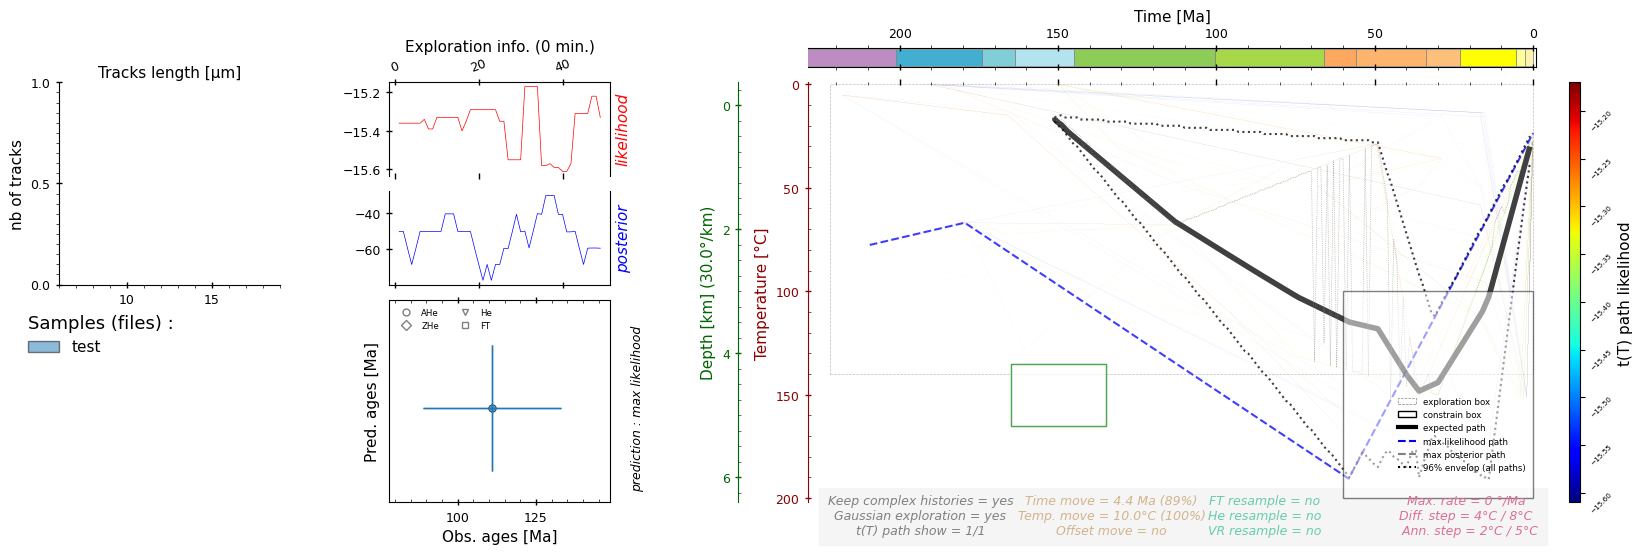

In [26]:
# Start the program

if __name__ == '__main__':
    if not QApplication.instance():
        app = QApplication(sys.argv)
    else:
        app = QApplication.instance()
    window = MyWindow()
    window.show()
    sys.exit(app.exec_())